### Testing already trained models

In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.multiprocessing as mp
from torch.distributed import init_process_group, destroy_process_group
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader
from astropy.io import fits
import pyxis.torch as pxt
import pyxis as px
import scipy.optimize as so

from networks import *
from train import *
import config

stem = 'CNN-CNN-flow_1m_LN'
data_dir = '/ocean/projects/phy250048p/shared/datasets/test_1m'
samp_dir = '/ocean/projects/phy250048p/shared/samples/samples_test_1m.csv'
fig_dir = '/ocean/projects/phy250048p/shared/figures/'
model_dir = f'/ocean/projects/phy250048p/shared/models/{stem}/'
loss_dir = '/ocean/projects/phy250048p/shared/models/losses/'
results_dir = '/ocean/projects/phy250048p/shared/results/'

In [2]:
def denormalize(samples):
    denorm = np.empty_like(samples)
    denorm[:, 0] = samples[:, 0]
    for i, par in enumerate(par_ranges.values()):
        low, high = par
        values = samples[:, i+1]
        values += 1
        values *= (high-low)/2
        values += low
        denorm[:, i+1] = values
    return denorm

In [3]:
def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), density=True)
    # NOTE : if you are using the latest version of python, in the above: 
    # instead of normed=True, use density=True
    
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    zero = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.))
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))


    # Array of Contour levels. Adjust according to the above
    levels = [zero, one_sigma, two_sigma][::-1]

    ###### 
    
    if ax == None:
        contour = plt.contourf(X, Y, Z, levels=levels, origin="lower", alpha=0.5, **contour_kwargs)

    else:
        contour = ax.contourf(X, Y, Z, levels=levels, origin="lower", alpha=0.5, **contour_kwargs)
    
    return contour

In [4]:
def make_g_scatter(g1, g2, g1_diff, g2_diff, c=None, cmap='viridis', s=1, cbar_name='SNR', save=True, filename=f'g_{stem}_scatter.jpg'):
    plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
    fig,axes = plt.subplots(1,2,sharey=True,figsize=(18,6))
    
    axes[0].scatter(g1, g1_diff, c=c, cmap=cmap, s=s)
    scat = axes[1].scatter(g2, g2_diff, c=c, cmap=cmap, s=s)
    axes[0].set_ylim(-0.1,0.1)
    
    for i in range(2):
        axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
        
    axes[0].set_xlabel(r'$g_+^{true}$',fontsize=20)
    axes[1].set_xlabel(r'$g_x^{true}$',fontsize=20)
    axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)
    
    axes[0].tick_params(axis='both',which='major',labelsize=15)
    axes[1].tick_params(axis='x',which='major',labelsize=15)
    
    fig.subplots_adjust(wspace=0.08,hspace=0.06)
    
    fig.subplots_adjust(right=0.8)
    
    cbar = plt.colorbar(scat, ax=axes)
    cbar.set_label(cbar_name)
    
    # plt.tight_layout()
    if save:
        plt.savefig(join(fig_dir, f'{stem}/{filename}'))

In [5]:
def make_g_contour(g1, g2, g1_diff, g2_diff, axis='12', nbins=25, mask=None, anti_mask=False, legend_str_list=[], save=True, filename=f'g_{stem}_contour.jpg'):
    plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
    fig = plt.figure(figsize=(8,6))
    fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

    if anti_mask:
        density_contour(g1[~mask], g1_diff[~mask], nbins, nbins, ax=axes[0], colors=['salmon', 'red'])
        contour = density_contour(g2[~mask], g2_diff[~mask], nbins, nbins, ax=axes[1], colors=['salmon', 'red'])
        handles, _ = contour.legend_elements()
    else:
        density_contour(g1, g1_diff, nbins, nbins, ax=axes[0], colors=['salmon', 'red'])
        contour = density_contour(g2, g2_diff, nbins, nbins, ax=axes[1], colors=['salmon', 'red'])
        handles, _ = contour.legend_elements()
    if mask is not None:
        density_contour(g1[mask], g1_diff[mask], nbins, nbins, ax=axes[0], colors=['lightsteelblue', 'cornflowerblue'])
        contour1 = density_contour(g2[mask], g2_diff[mask], nbins, nbins, ax=axes[1], colors=['lightsteelblue', 'cornflowerblue'])
        handles1, _ = contour1.legend_elements()
        handles += handles1
    axes[0].set_ylim(-0.1,0.1)
    
    for i in range(2):
        axes[i].axhline(0,color='k',linestyle='--',linewidth=3)

    if axis == '12':
        axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
        axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
    elif axis == 'pc':
        axes[0].set_xlabel(r'$g_+^{true}$',fontsize=20)
        axes[1].set_xlabel(r'$g_x^{true}$',fontsize=20)
    axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)
    
    axes[0].tick_params(axis='both',which='major',labelsize=15)
    axes[1].tick_params(axis='x',which='major',labelsize=15)
    
    plt.legend(handles, legend_str_list, fontsize=16)
    
    fig1.subplots_adjust(wspace=0.08,hspace=0.06)
    
    fig1.subplots_adjust(right=0.8)
    
    plt.tight_layout()
    if save:
        plt.savefig(join(fig_dir, f'{stem}/{filename}'))

In [3]:
os.makedirs(join(fig_dir, stem), exist_ok=True)

#### Generate loss plot

In [2]:
losses = pd.read_csv(join(loss_dir, f'losses_{stem}.csv'))
# nans_infs = pd.read_csv(join(loss_dir, f'nans_infs_{stem}.csv'))

In [3]:
train_losses = losses.iloc[0, :]
valid_losses = losses.iloc[1, :]
epoch = np.arange(1, losses.shape[1]+1)

In [4]:
valid_losses[-2]

/var/tmp/ipykernel_54167/237616781.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valid_losses[-2]


0.021853602564428

In [5]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})

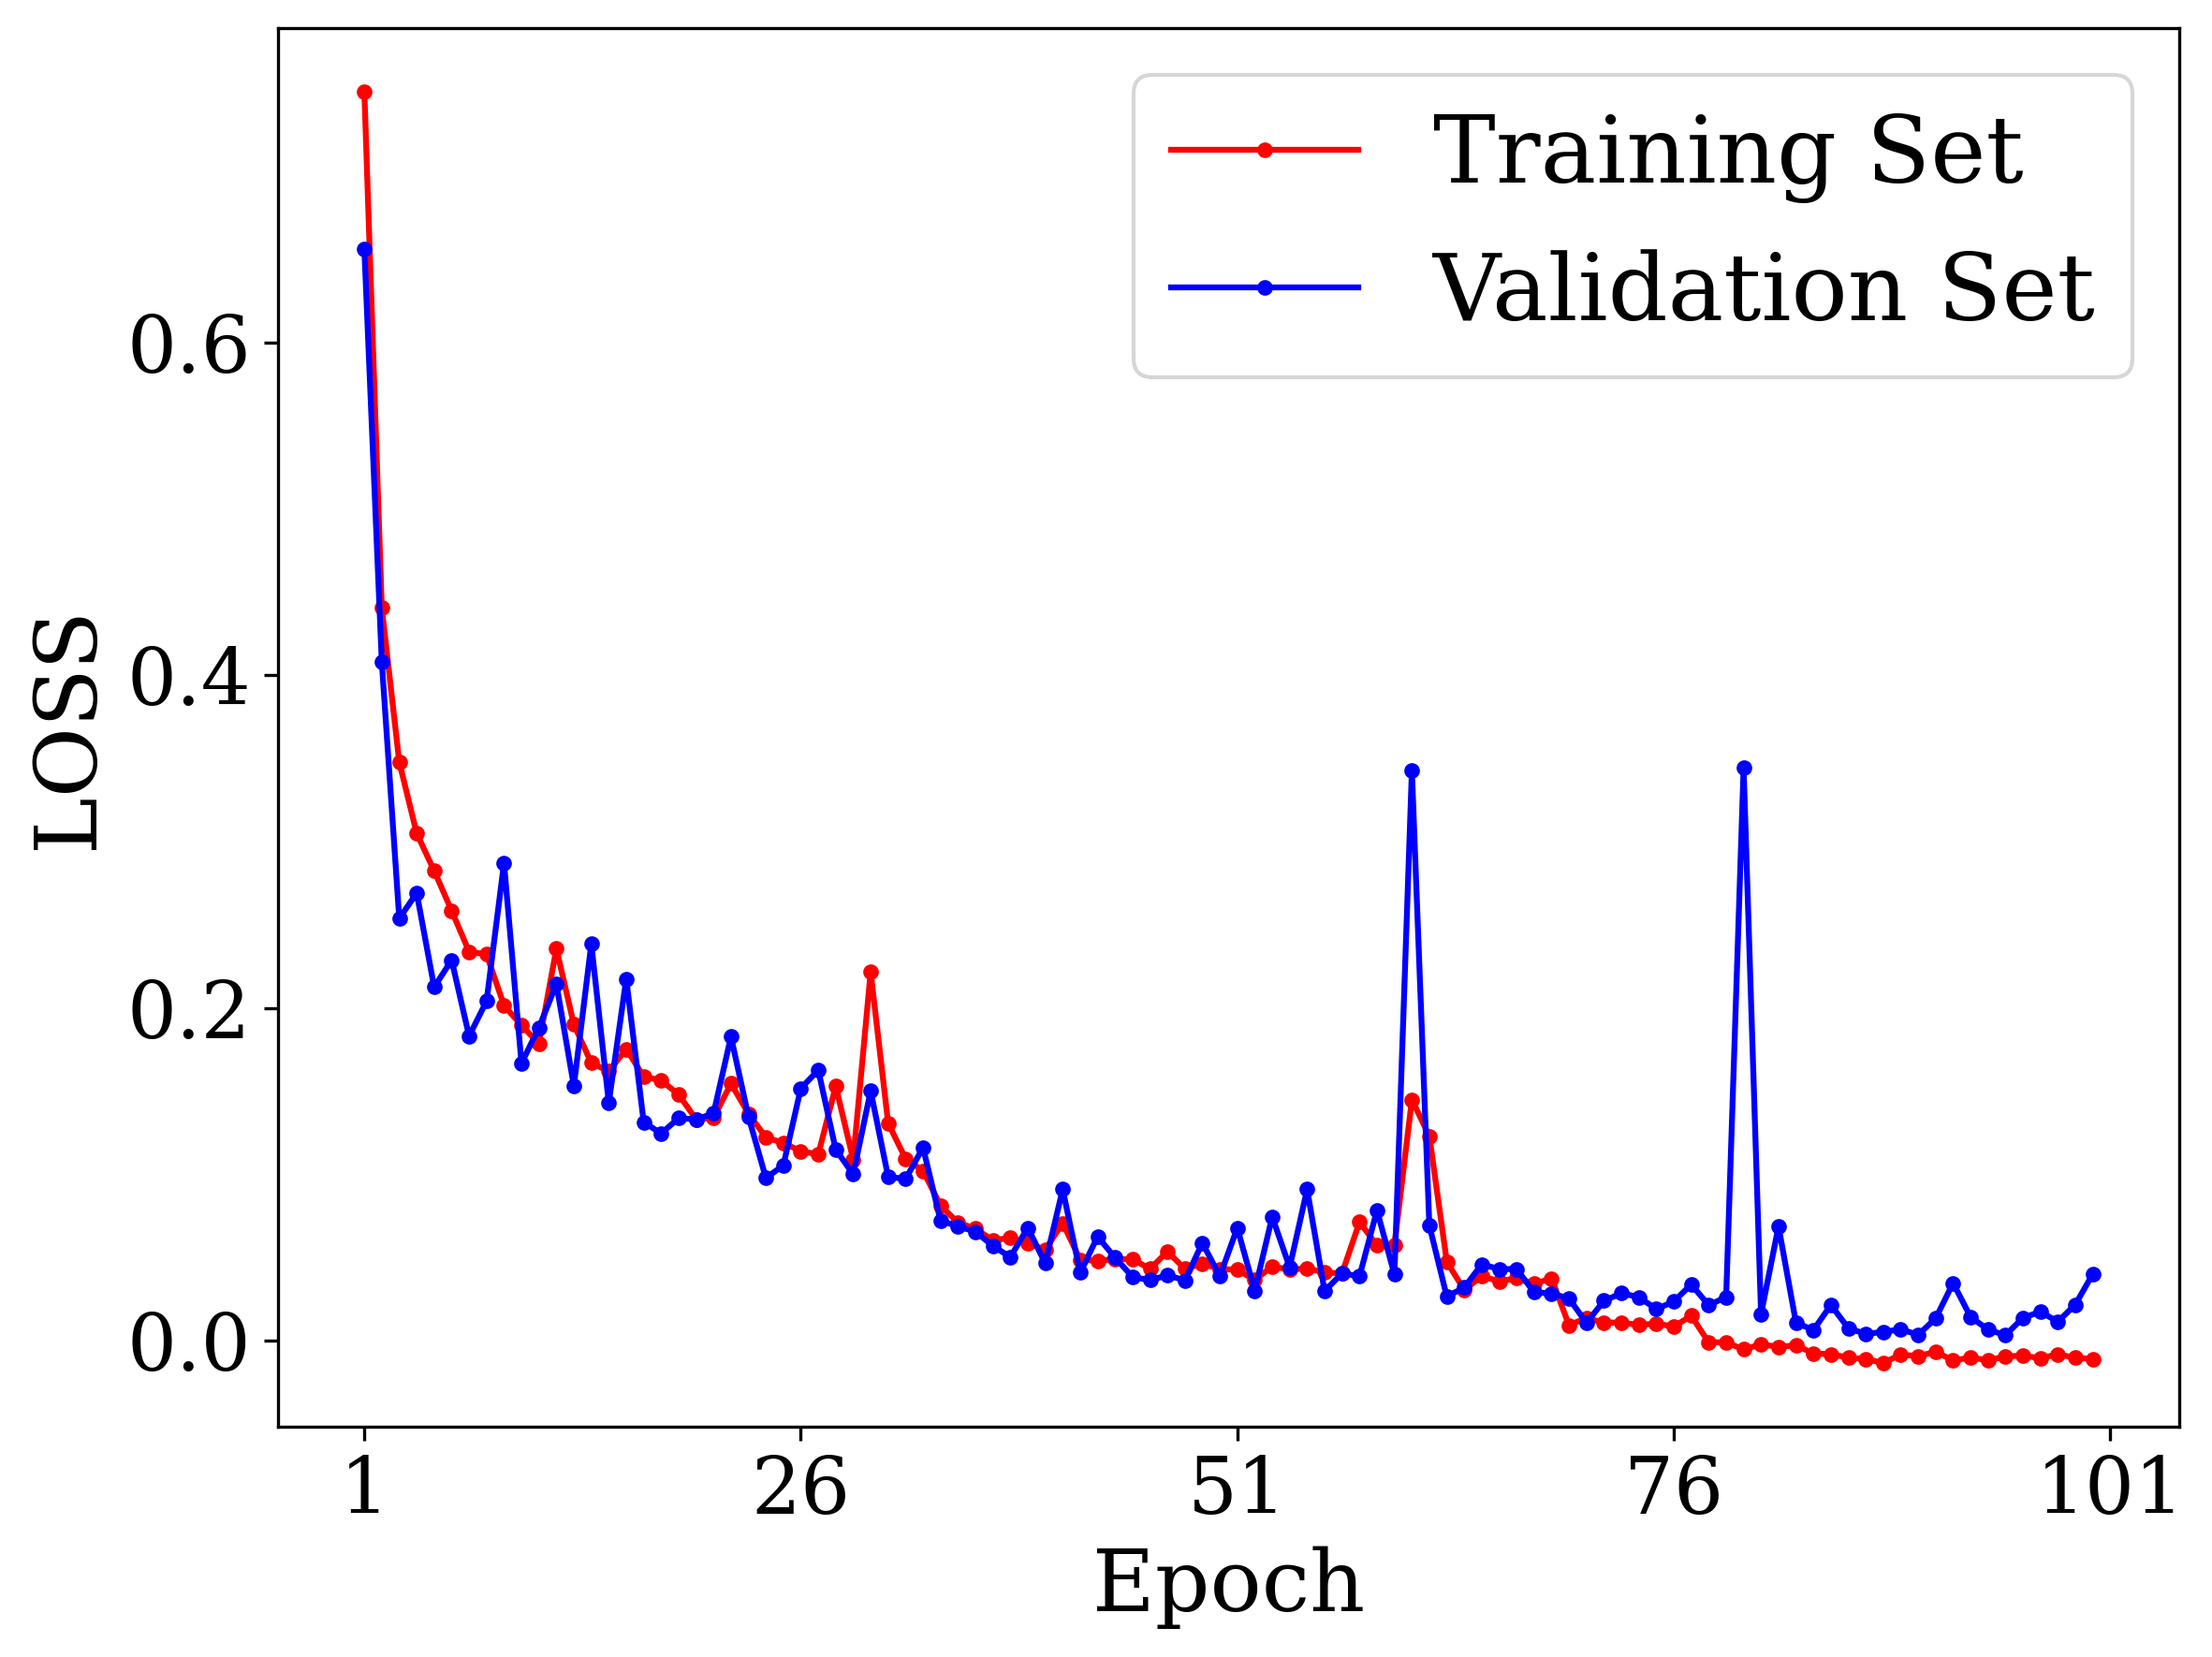

In [6]:
plt.figure(figsize=(8, 6))

plt.plot(epoch[0:], train_losses[0:], 'r.-', label="Training Set")
plt.plot(epoch[0:], valid_losses[0:], 'b.-', label='Validation Set')

plt.xlabel("Epoch", fontsize=22)
plt.ylabel("LOSS", fontsize=22)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xticks(np.linspace(1, losses.shape[1]+1, 5))
# plt.yscale('log')
plt.legend(fontsize=24)
plt.tight_layout()
plt.savefig(join(fig_dir, f'losses/{stem}_loss.jpg'))
plt.show()

### Start here to test model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model_file = join(model_dir, f'{stem}97')
model = load_model(mode=0, path=model_file,strict=True, assign=True, device=device)

In [8]:
print(model)

ForkCNN(
  (img_net): ImgCNN(
    (cnn_img): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (7): ResidualBlock(
        (cnn1): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (cnn2): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(

In [9]:
# Get data loader
test_args = list(config.test.values())
test_ds = pxt.TorchDataset(data_dir)
test_dl = DataLoader(test_ds,
                     batch_size=100,
                     pin_memory=True,
                     shuffle=False,)

In [10]:
len(test_ds)

100000

### Code to test point estimates

In [14]:
pred, true, loss, SNR = predict(2, test_dl, model, device=device)
print('Test LOSS:',loss)

Test LOSS: 0.4308413742244381


In [15]:
diff = pred - true

In [16]:
par_ranges = config.par_ranges

In [18]:
pred_den = denormalize(pred)
true_den = denormalize(true)

In [19]:
diff = pred_den - true_den

In [17]:
os.system(f'mkdir /data/wxs0703/kl-nn/figures/{stem}')

mkdir: cannot create directory ‘/data/wxs0703/kl-nn/figures/CNN-CNN-flow_1m_LN_pretrained’: No such file or directory


256

### g1, g2

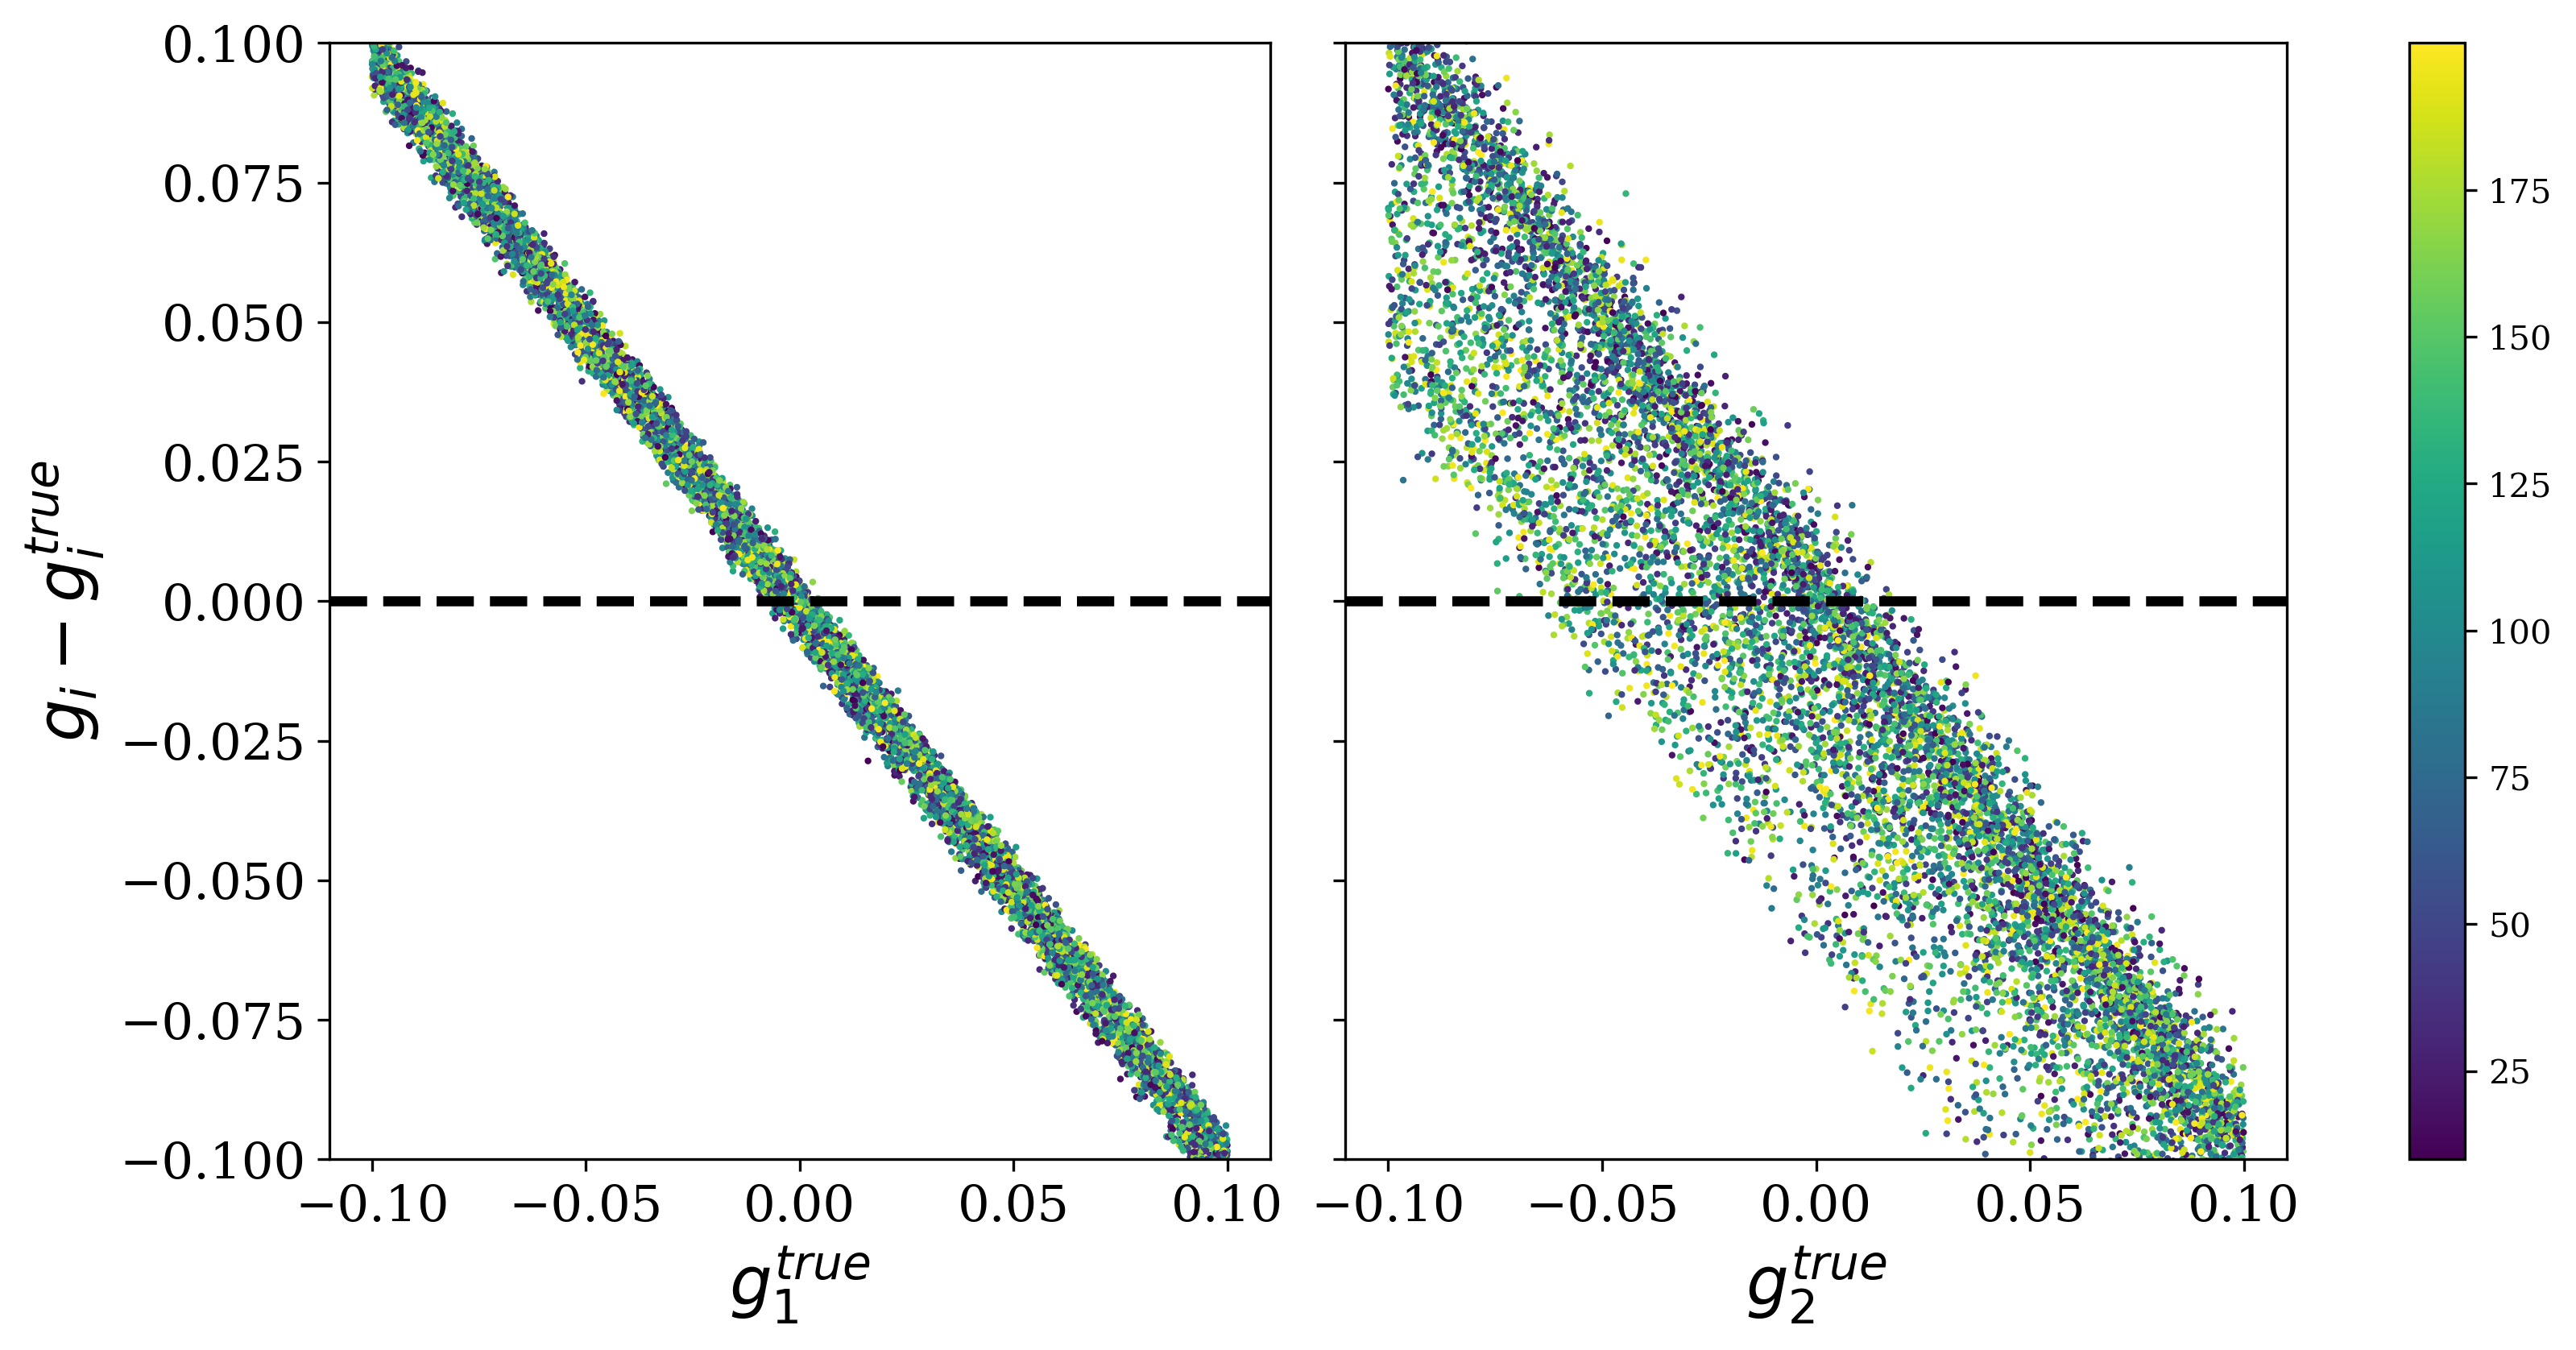

In [15]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig,axes = plt.subplots(1,2,sharey=True,figsize=(15,6))

g1_true = true[:,1]
g1_diff = diff[:,1]
g2_true = true[:,2]
g2_diff = diff[:,2]
snr_mask = SNR > 100

axes[0].scatter(g1_true, g1_diff, c=SNR, cmap='viridis', s=1)
scat = axes[1].scatter(g2_true, g2_diff, c=SNR, cmap='viridis', s=1)
axes[0].set_ylim(-0.1,0.1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

fig.subplots_adjust(wspace=0.08,hspace=0.06)

fig.subplots_adjust(right=0.8)

plt.colorbar(scat, ax=axes)

# plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/g_{stem}_contour_snr.jpg'))
plt.show()

<Figure size 2400x1800 with 0 Axes>

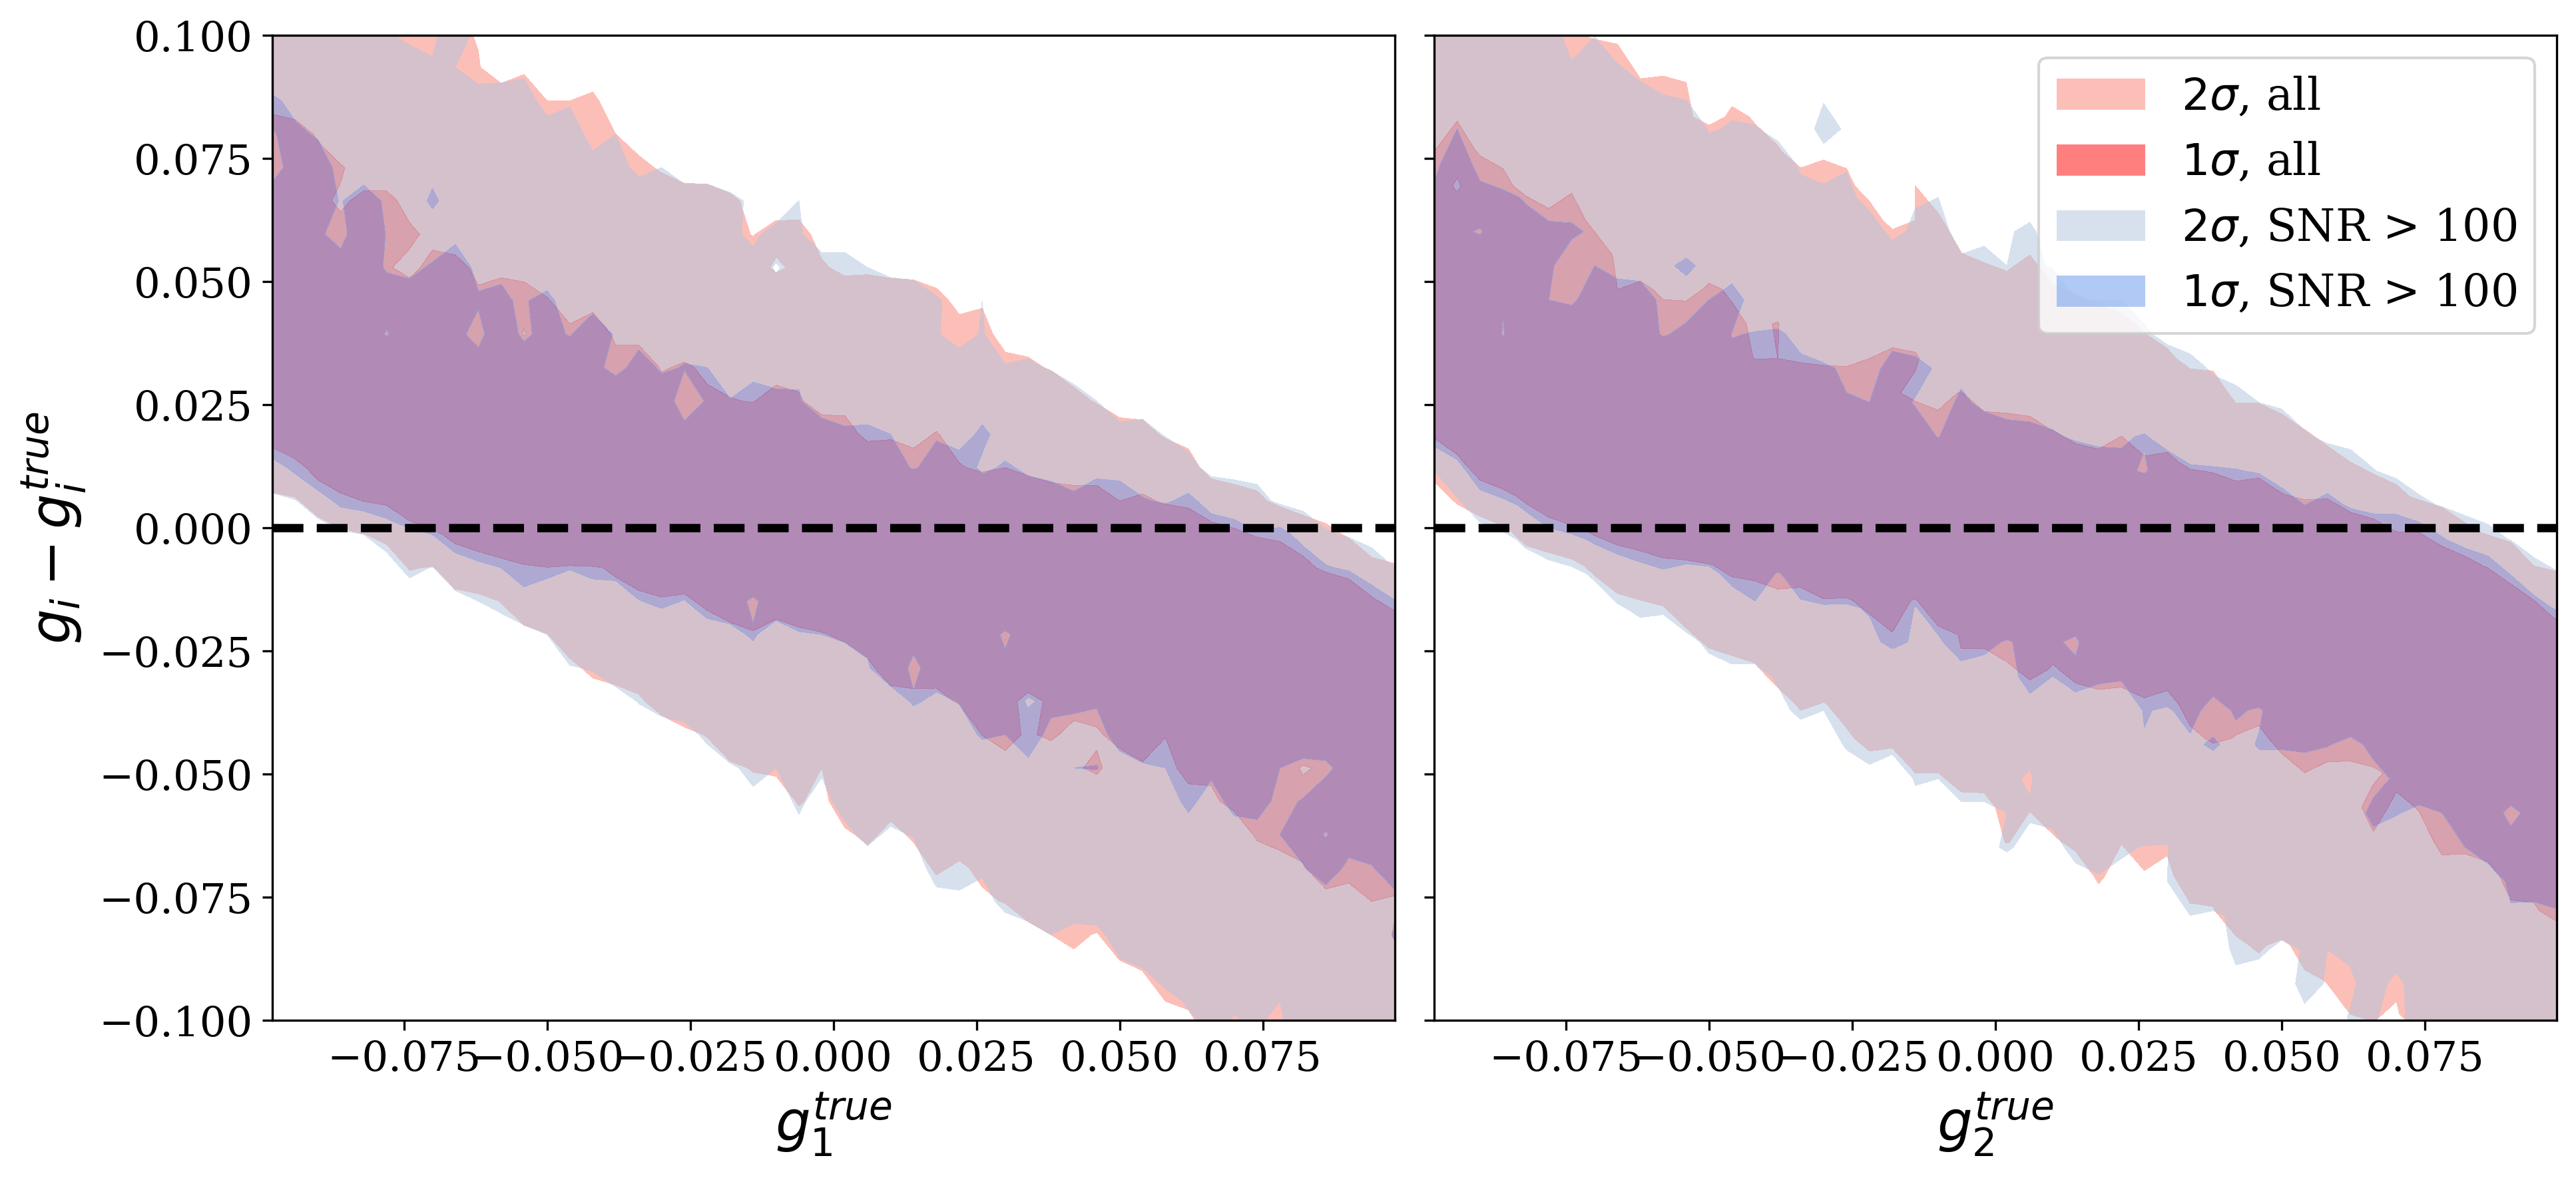

In [22]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

g1_true = true[:,1]
g1_diff = diff[:,1]
g2_true = true[:,2]
g2_diff = diff[:,2]
snr_mask = SNR > 100

density_contour(g1_true, g1_diff, 50, 50, ax=axes[0], colors=['salmon', 'red'])
contour = density_contour(g2_true, g2_diff, 50, 50, ax=axes[1], colors=['salmon', 'red'])
density_contour(g1_true[snr_mask], g1_diff[snr_mask], 50, 50, ax=axes[0], colors=['lightsteelblue', 'cornflowerblue'])
contour1 = density_contour(g2_true[snr_mask], g2_diff[snr_mask], 50, 50, ax=axes[1], colors=['lightsteelblue', 'cornflowerblue'])
axes[0].set_ylim(-0.1,0.1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
handles1, _ = contour1.legend_elements()
handles += handles1
plt.legend(handles, [r'$2\sigma$, all', r'$1\sigma$, all', 
                     r'$2\sigma$, SNR > 100', r'$1\sigma$, SNR > 100'], fontsize=16)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/g_{stem}_contour_snr.jpg'))
plt.show()

<Figure size 2400x1800 with 0 Axes>

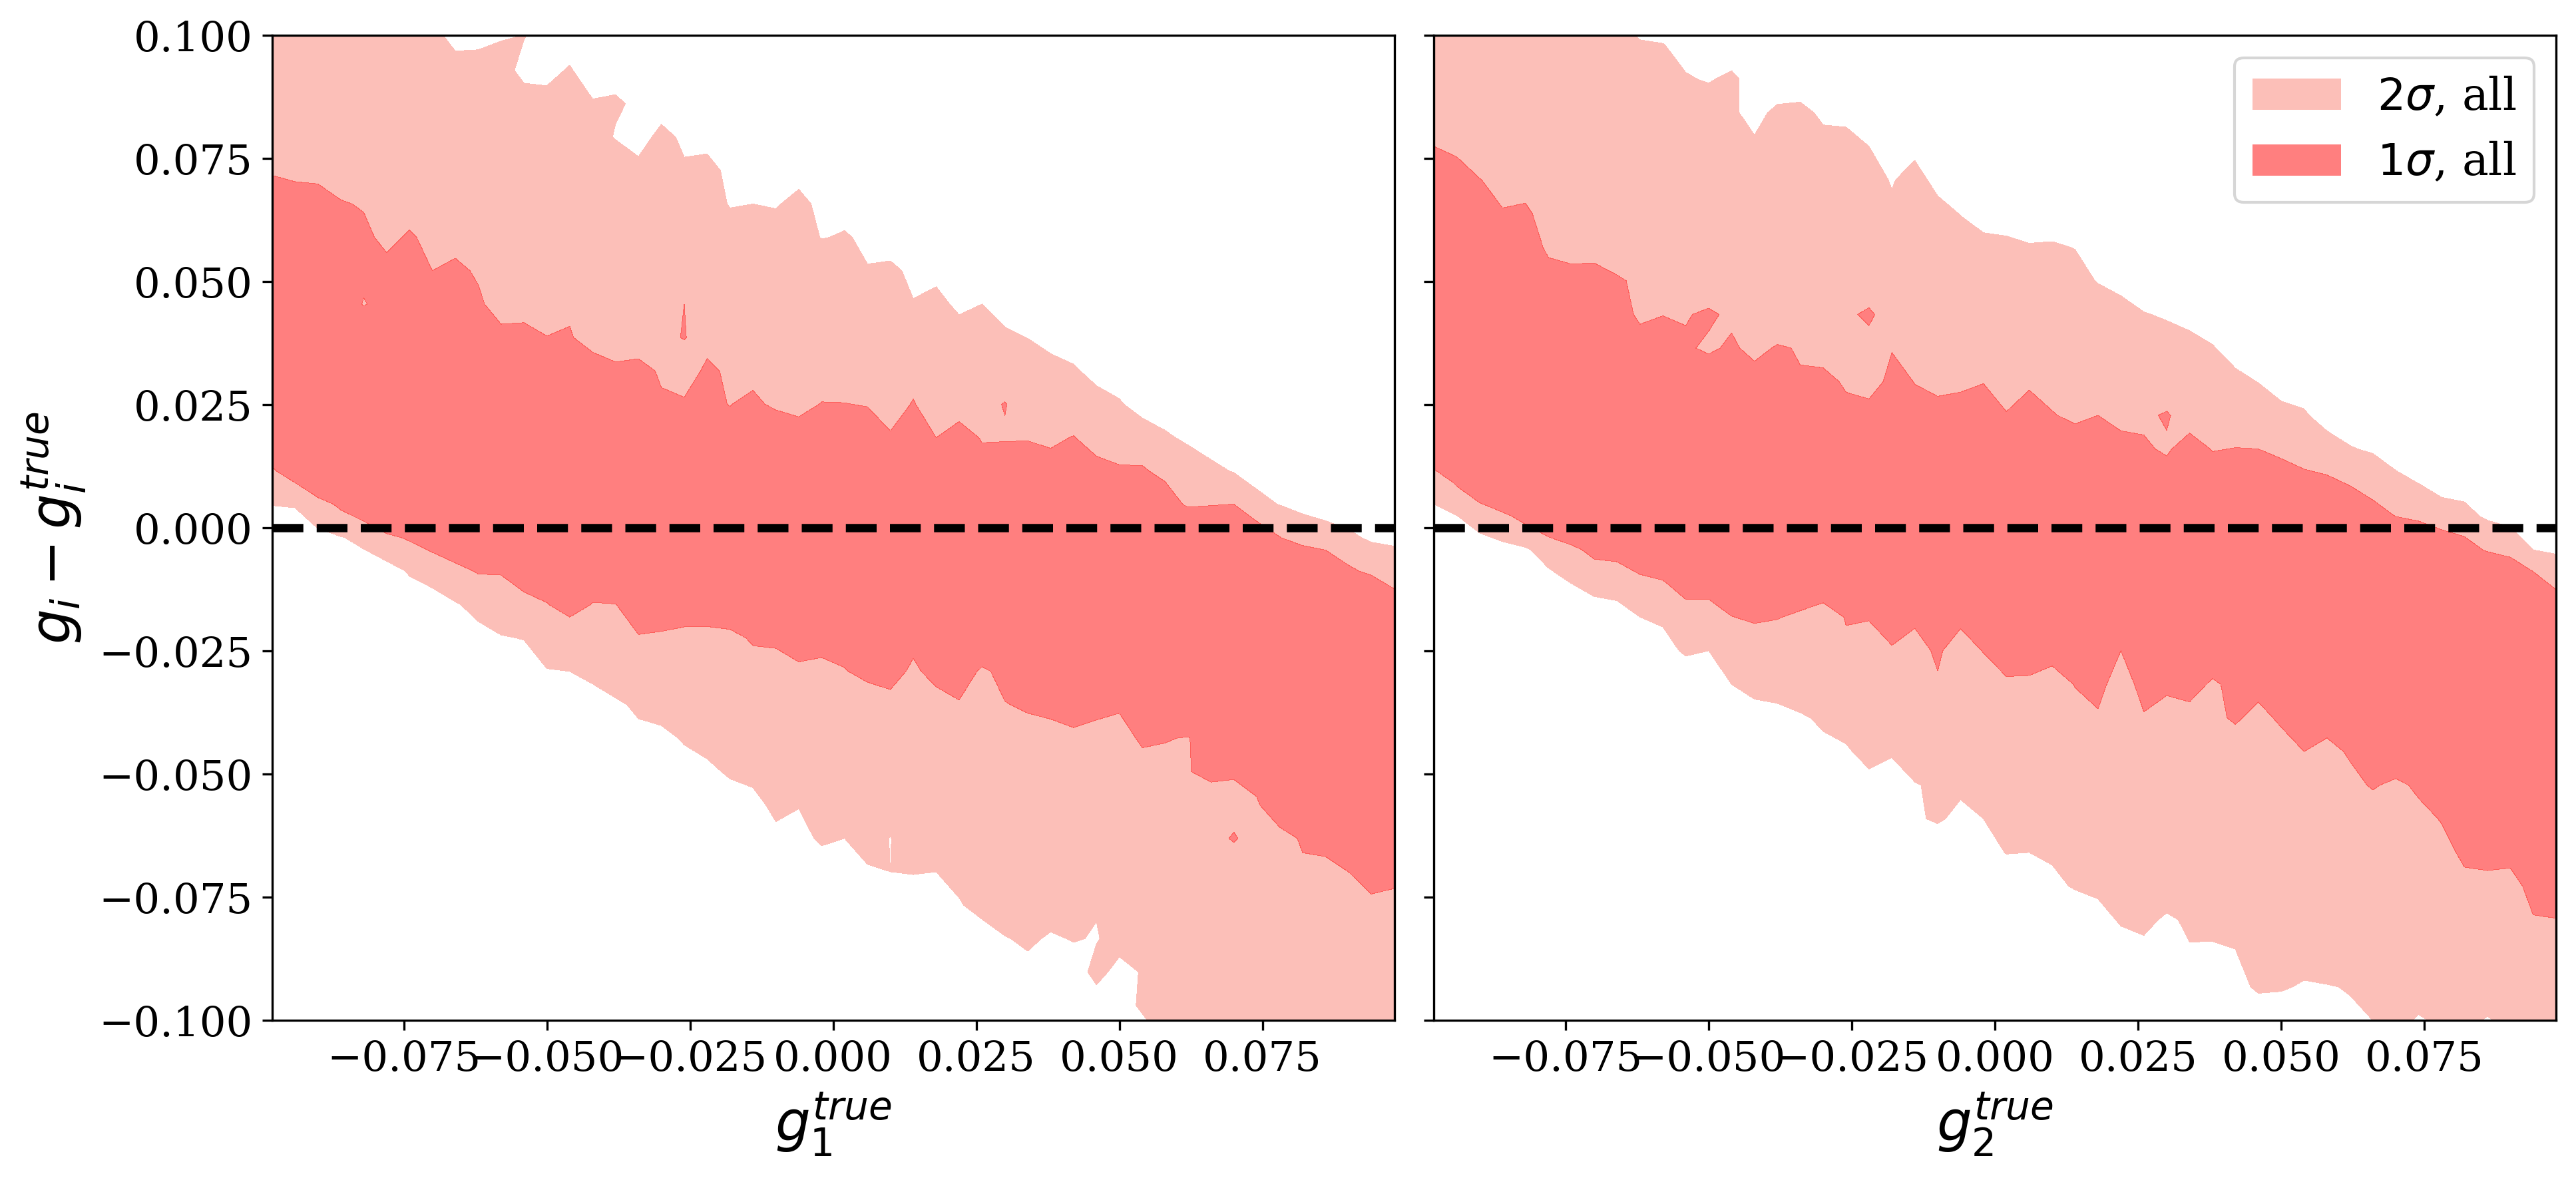

In [25]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

g1_true = true[:,1]
g1_diff = diff[:,1]
g2_true = true[:,2]
g2_diff = diff[:,2]

density_contour(g1_true, g1_diff, 50, 50, ax=axes[0], colors=['salmon', 'red'])
contour = density_contour(g2_true, g2_diff, 50, 50, ax=axes[1], colors=['salmon', 'red'])
axes[0].set_ylim(-0.1,0.1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$, all', r'$1\sigma$, all'], fontsize=16)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/g_{stem}_contour.jpg'))
plt.show()

<Figure size 2400x1800 with 0 Axes>

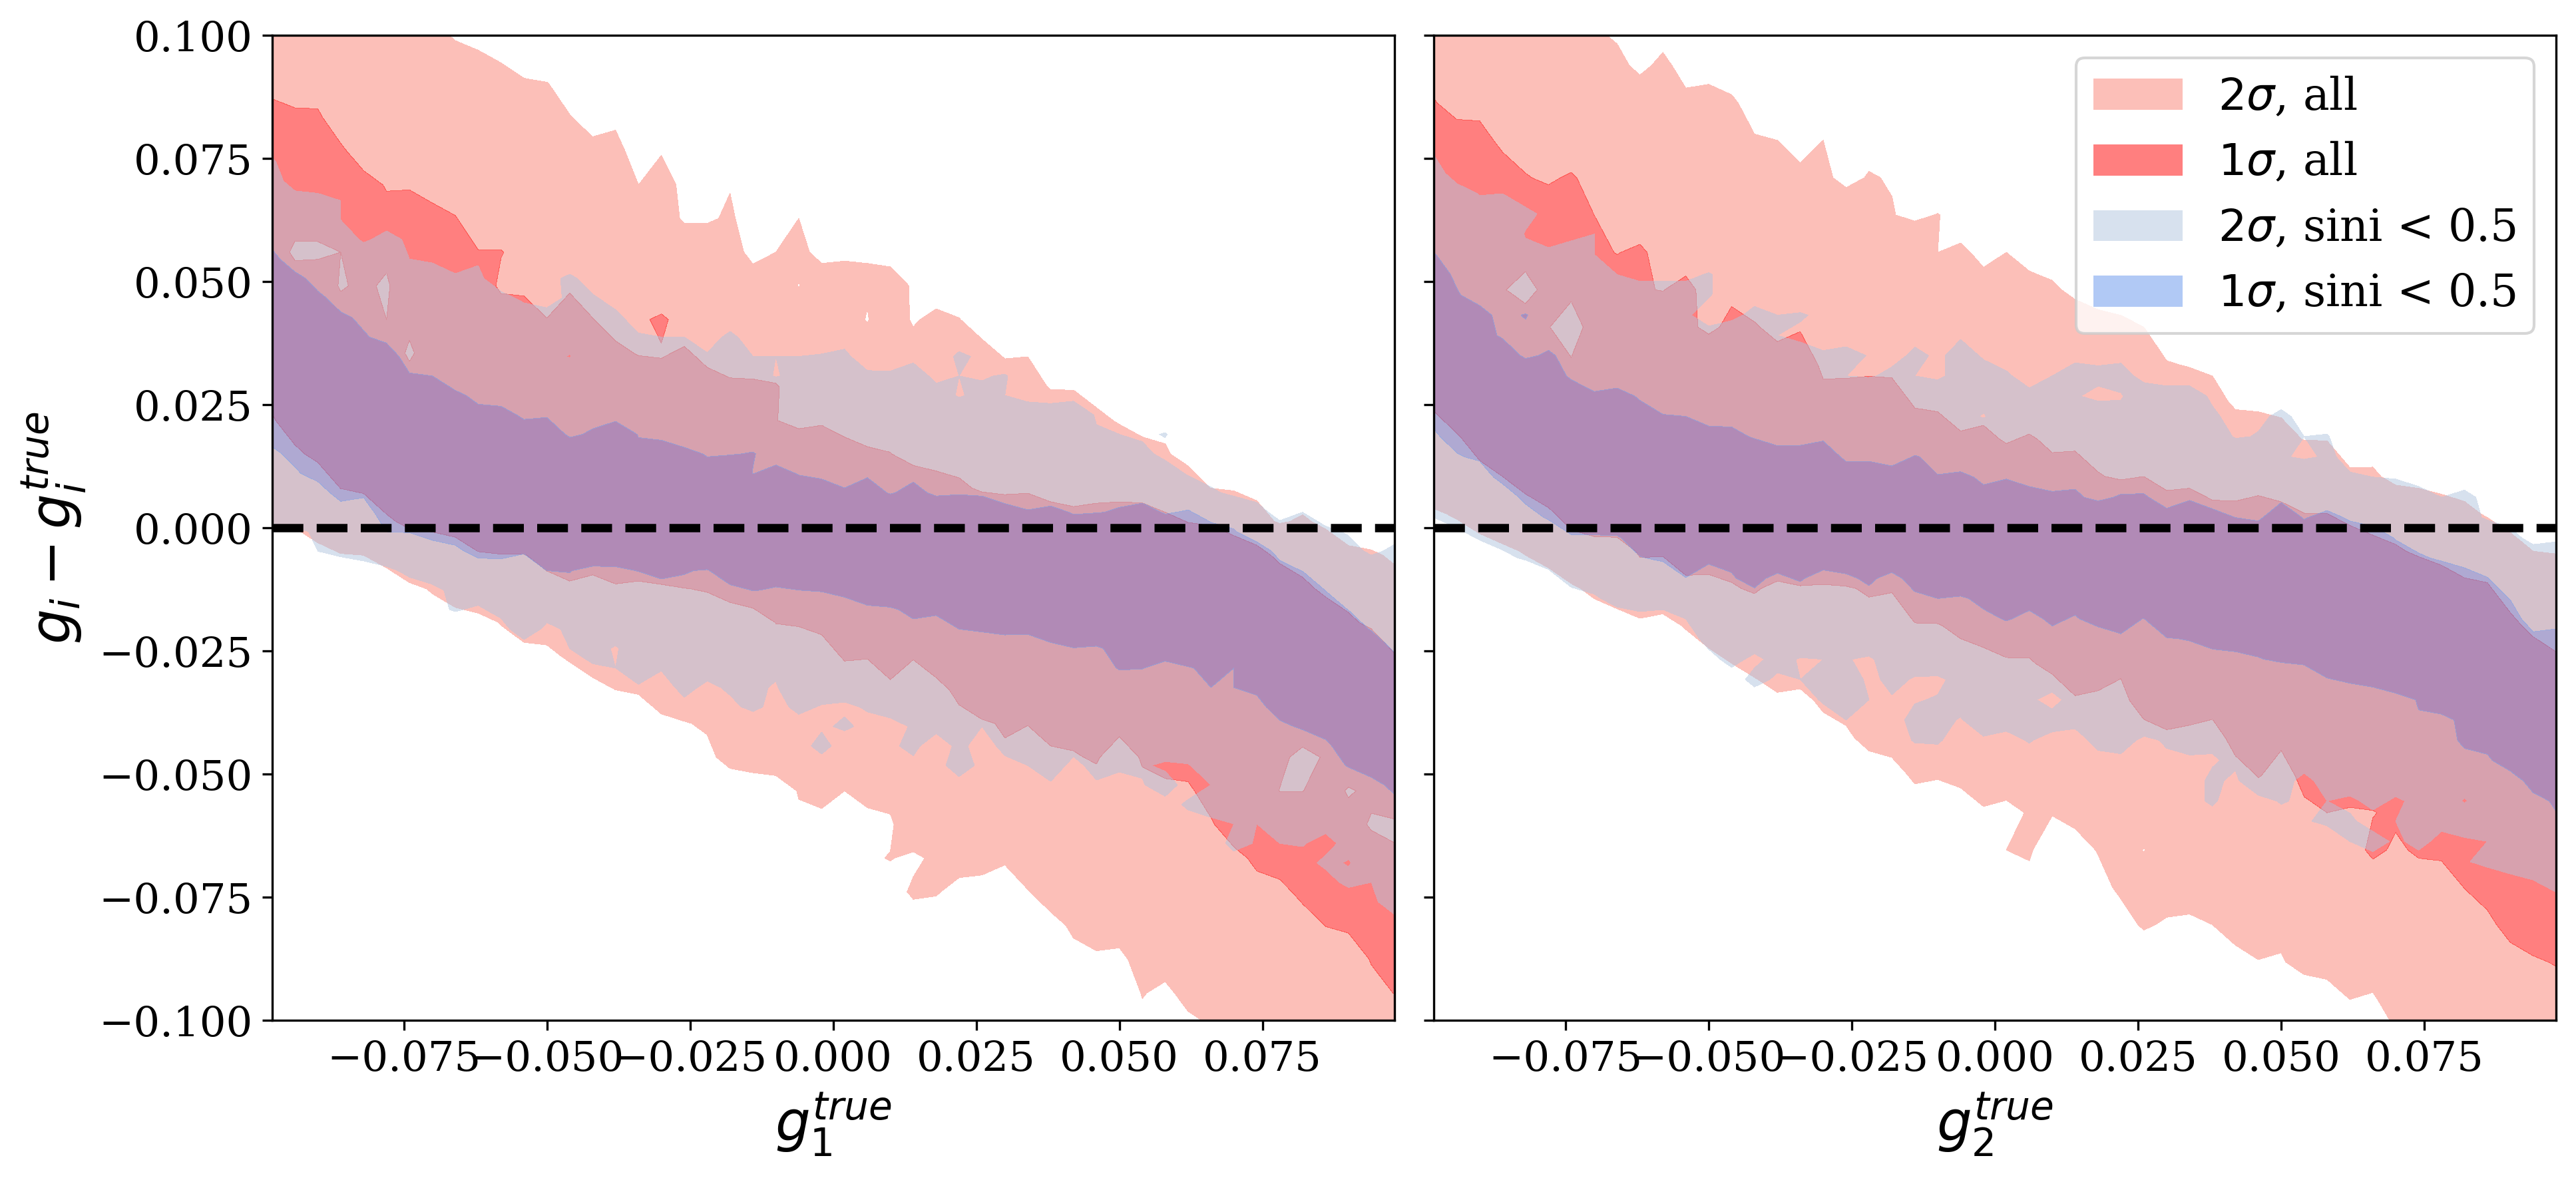

In [18]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(8,6))
fig1,axes = plt.subplots(1,2,sharey=True,figsize=(13,6))

g1_true = true[:,1]
g1_diff = diff[:,1]
g2_true = true[:,2]
g2_diff = diff[:,2]
sini_mask = true[:, 4] < 0.5

density_contour(g1_true, g1_diff, 50, 50, ax=axes[0], colors=['salmon', 'red'])
contour = density_contour(g2_true, g2_diff, 50, 50, ax=axes[1], colors=['salmon', 'red'])
density_contour(g1_true[sini_mask], g1_diff[sini_mask], 50, 50, ax=axes[0], colors=['lightsteelblue', 'cornflowerblue'])
contour1 = density_contour(g2_true[sini_mask], g2_diff[sini_mask], 50, 50, ax=axes[1], colors=['lightsteelblue', 'cornflowerblue'])
axes[0].set_ylim(-0.1,0.1)

for i in range(2):
    axes[i].axhline(0,color='k',linestyle='--',linewidth=3)
    
axes[0].set_xlabel(r'$g_1^{true}$',fontsize=20)
axes[1].set_xlabel(r'$g_2^{true}$',fontsize=20)
axes[0].set_ylabel(r'$g_i-g_i^{true}$',fontsize=20)

axes[0].tick_params(axis='both',which='major',labelsize=15)
axes[1].tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
handles1, _ = contour1.legend_elements()
handles += handles1
plt.legend(handles, [r'$2\sigma$, all', r'$1\sigma$, all', 
                     r'$2\sigma$, sini < 0.5', r'$1\sigma$, sini < 0.5'], fontsize=16)

fig1.subplots_adjust(wspace=0.08,hspace=0.06)

fig1.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/g_{stem}_contour_2.jpg'))
plt.show()

### theta_int

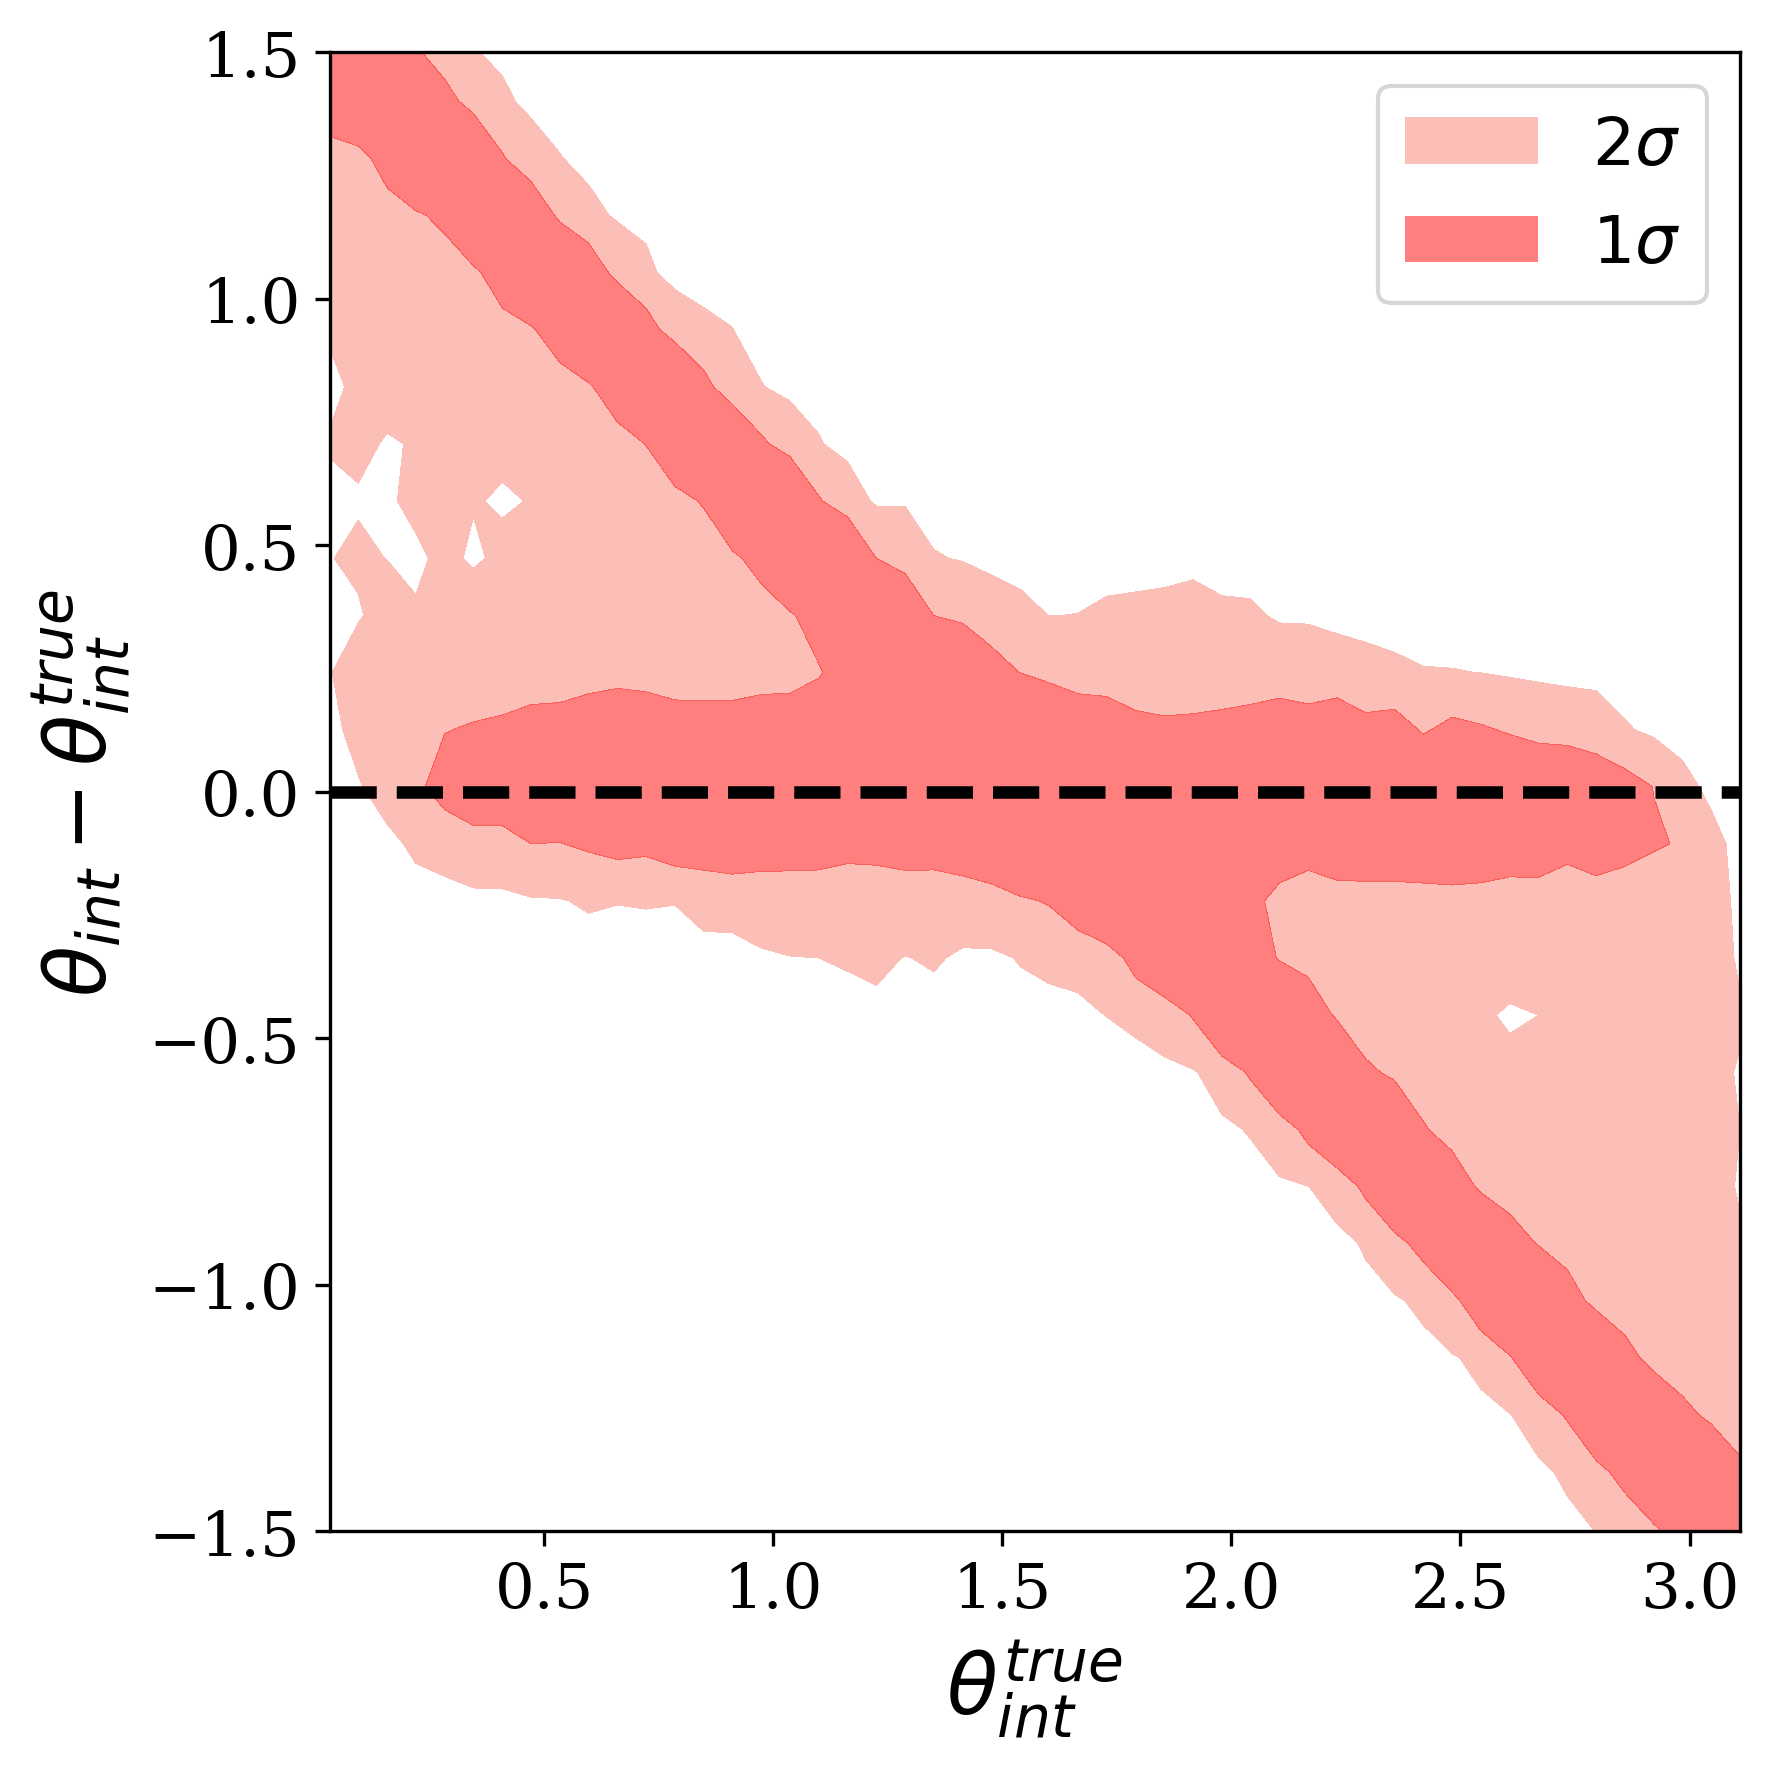

In [19]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(6,6))

theta_true = true[:,3]
theta_diff = diff[:,3]

contour = density_contour(theta_true, theta_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-1.5, 1.5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$\theta_{int}^{true}$',fontsize=20)
plt.ylabel(r'$\theta_{int}-\theta_{int}^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)
plt.tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

fig.subplots_adjust(wspace=0.08,hspace=0.06)

fig.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/theta_{stem}_contour.jpg'))
plt.show()

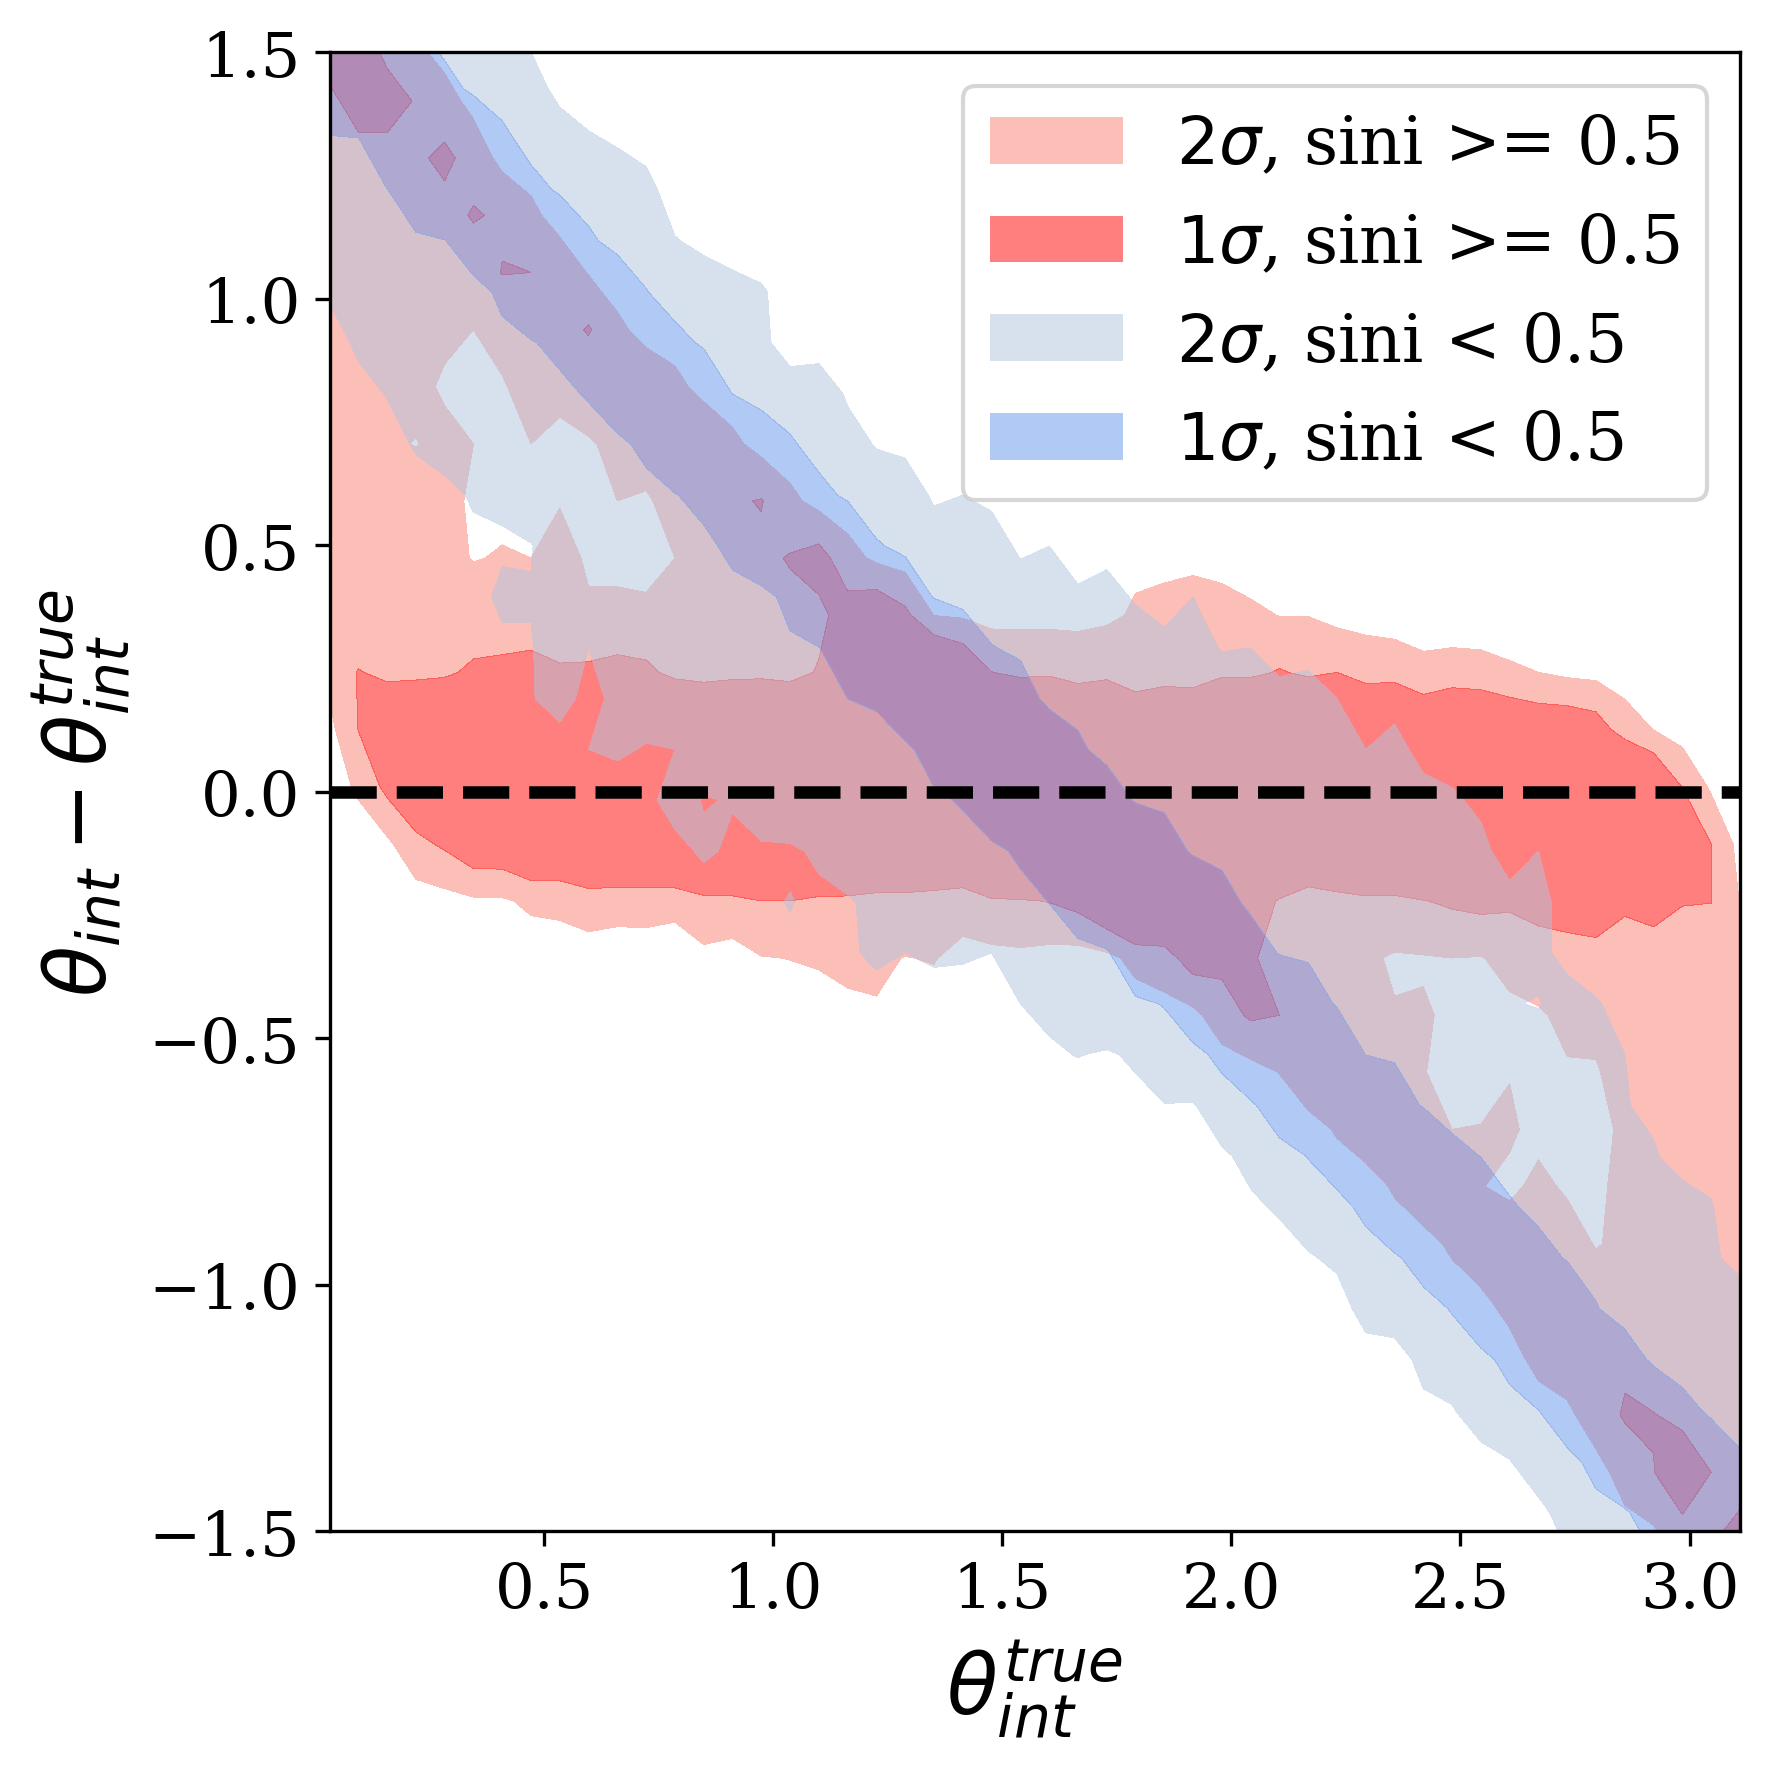

In [20]:
plt.rcParams.update({"text.usetex": False, "font.family": "serif", "figure.dpi": 300})
fig = plt.figure(figsize=(6,6))

theta_true = true[:,3]
theta_diff = diff[:,3]
sini_mask = true[:, 4] < 0.5

contour = density_contour(theta_true[~sini_mask], theta_diff[~sini_mask], 50, 50, colors=['salmon', 'red'])
contour1 = density_contour(theta_true[sini_mask], theta_diff[sini_mask], 50, 50, colors=['lightsteelblue', 'cornflowerblue'])
plt.ylim(-1.5, 1.5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$\theta_{int}^{true}$',fontsize=20)
plt.ylabel(r'$\theta_{int}-\theta_{int}^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)
plt.tick_params(axis='x',which='major',labelsize=15)

handles, _ = contour.legend_elements()
handles1, _ = contour1.legend_elements()
handles += handles1
plt.legend(handles, [r'$2\sigma$, sini >= 0.5', r'$1\sigma$, sini >= 0.5', 
                     r'$2\sigma$, sini < 0.5', r'$1\sigma$, sini < 0.5'], fontsize=16)

fig.subplots_adjust(wspace=0.08,hspace=0.06)

fig.subplots_adjust(right=0.8)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/theta_{stem}_contour_2.jpg'))
plt.show()

### sini

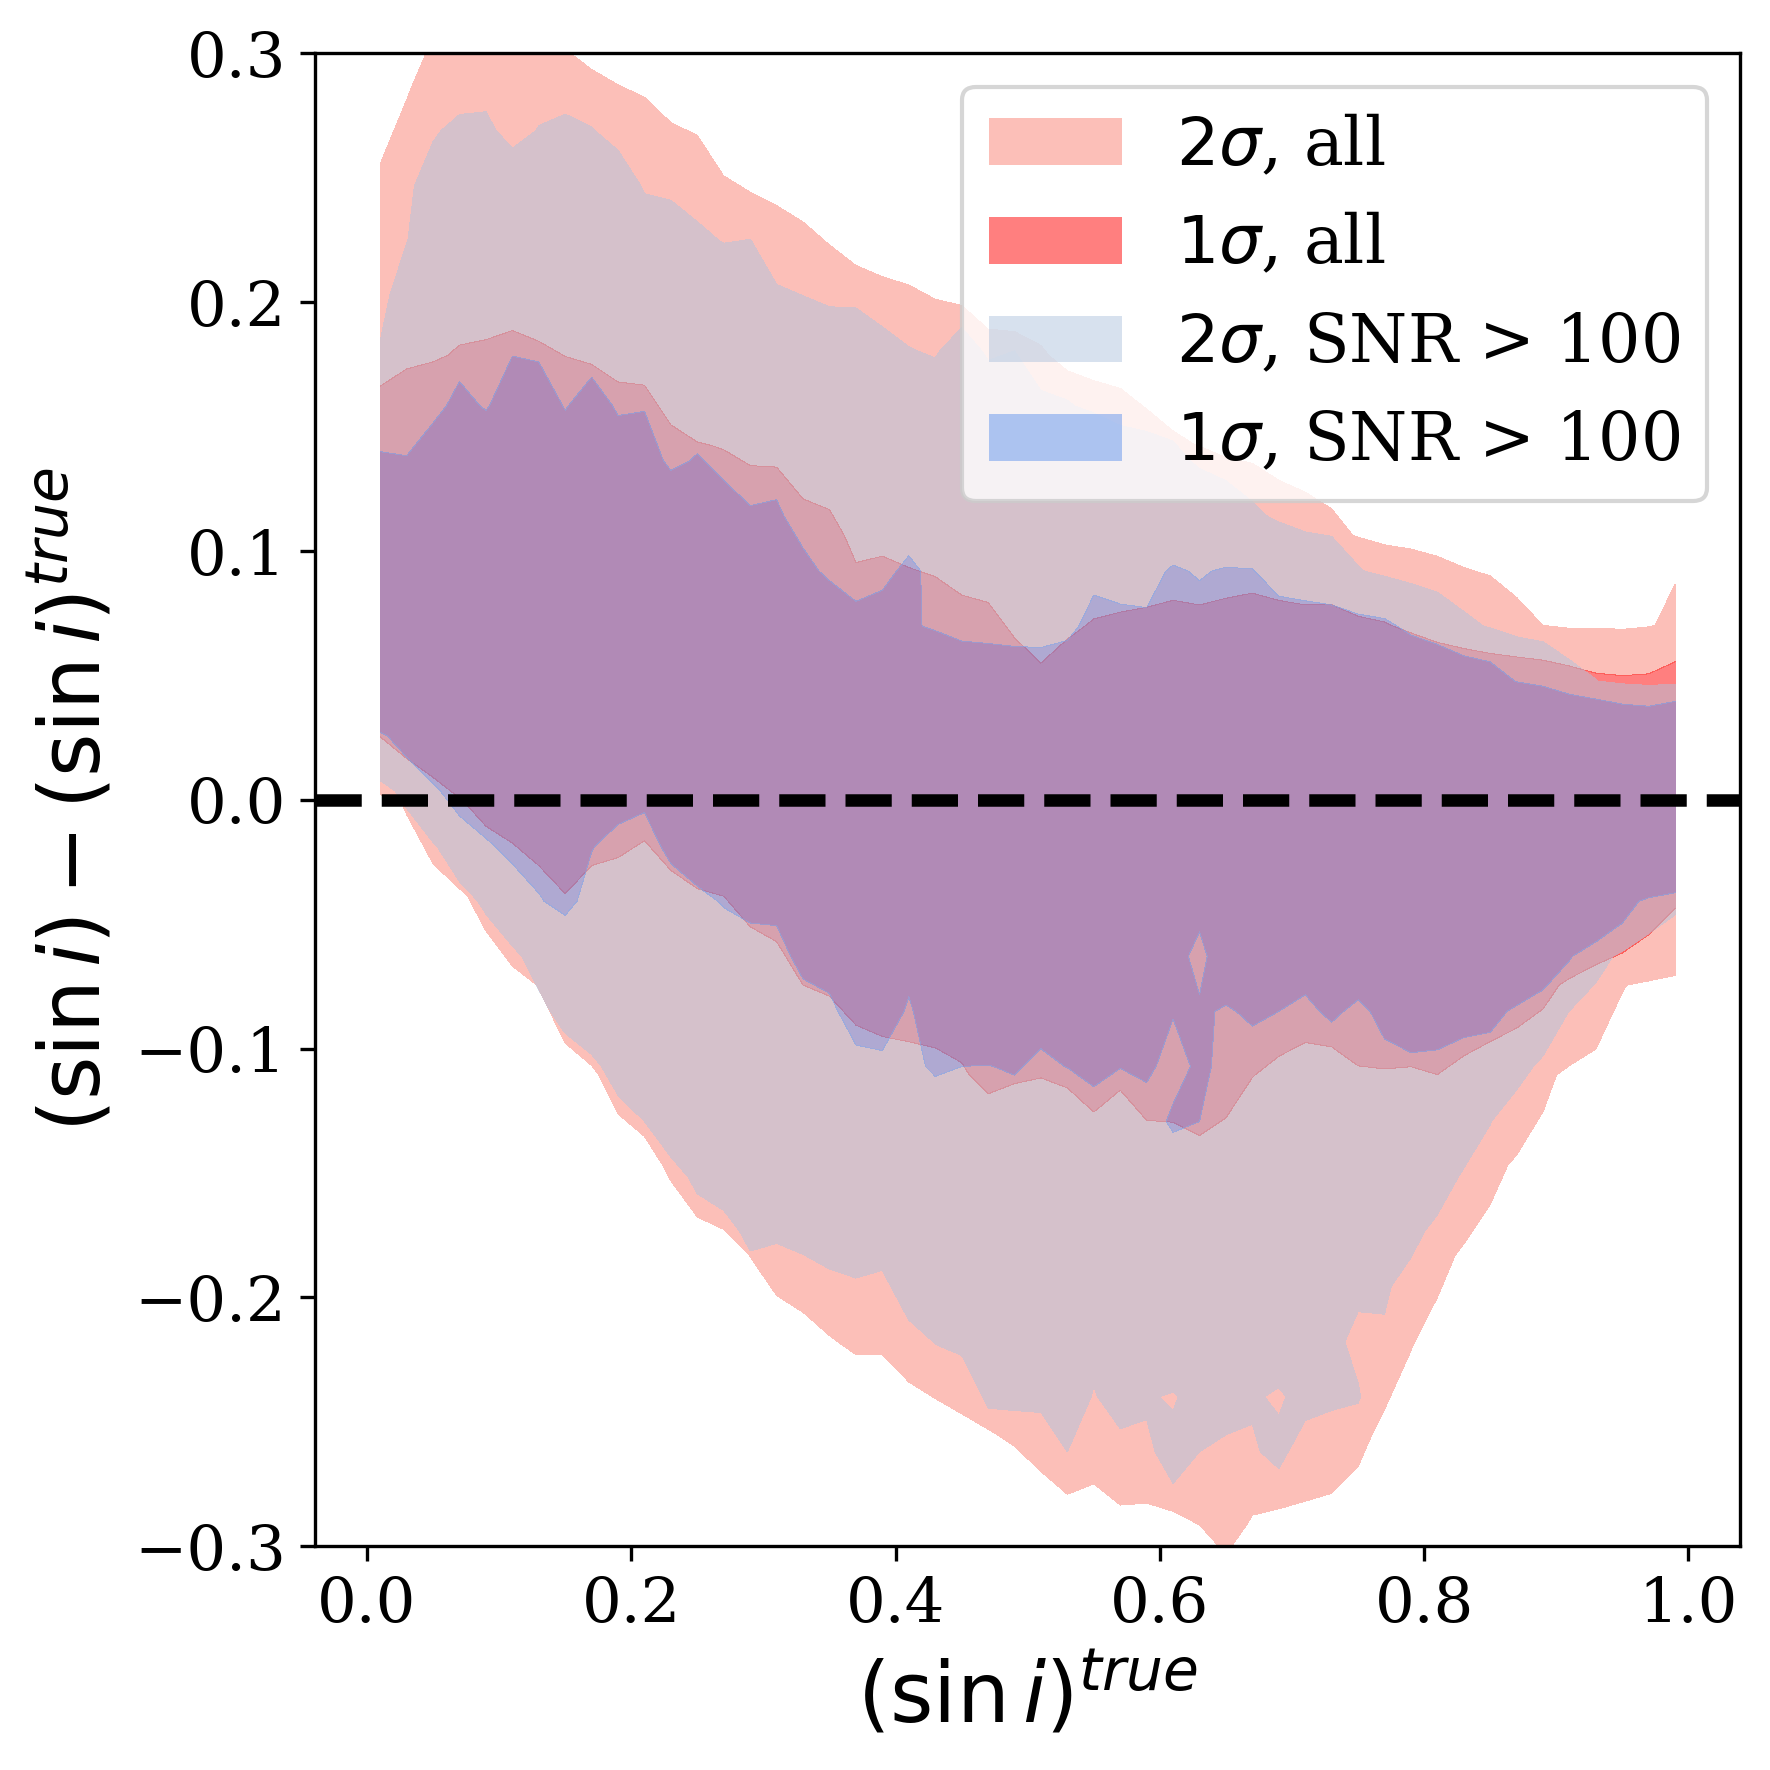

In [24]:
fig = plt.figure(figsize=(6,6))

sini_true = true[:,4]
sini_diff = diff[:,4]
snr_mask = SNR > 160

contour = density_contour(sini_true, sini_diff, 50, 50, colors=['salmon', 'red'])
contour1 = density_contour(sini_true[snr_mask], sini_diff[snr_mask], 50, 50, colors=['lightsteelblue', 'cornflowerblue'])
plt.ylim(-0.3,0.3)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$(\sin i)^{true}$',fontsize=20)
plt.ylabel(r'$(\sin i)-(\sin i)^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
handles1, _ = contour1.legend_elements()
handles += handles1
plt.legend(handles, [r'$2\sigma$, all', r'$1\sigma$, all',
                     r'$2\sigma$, SNR > 100', r'$1\sigma$, SNR > 100'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/sini_{stem}_contour_snr.jpg'))
plt.show()

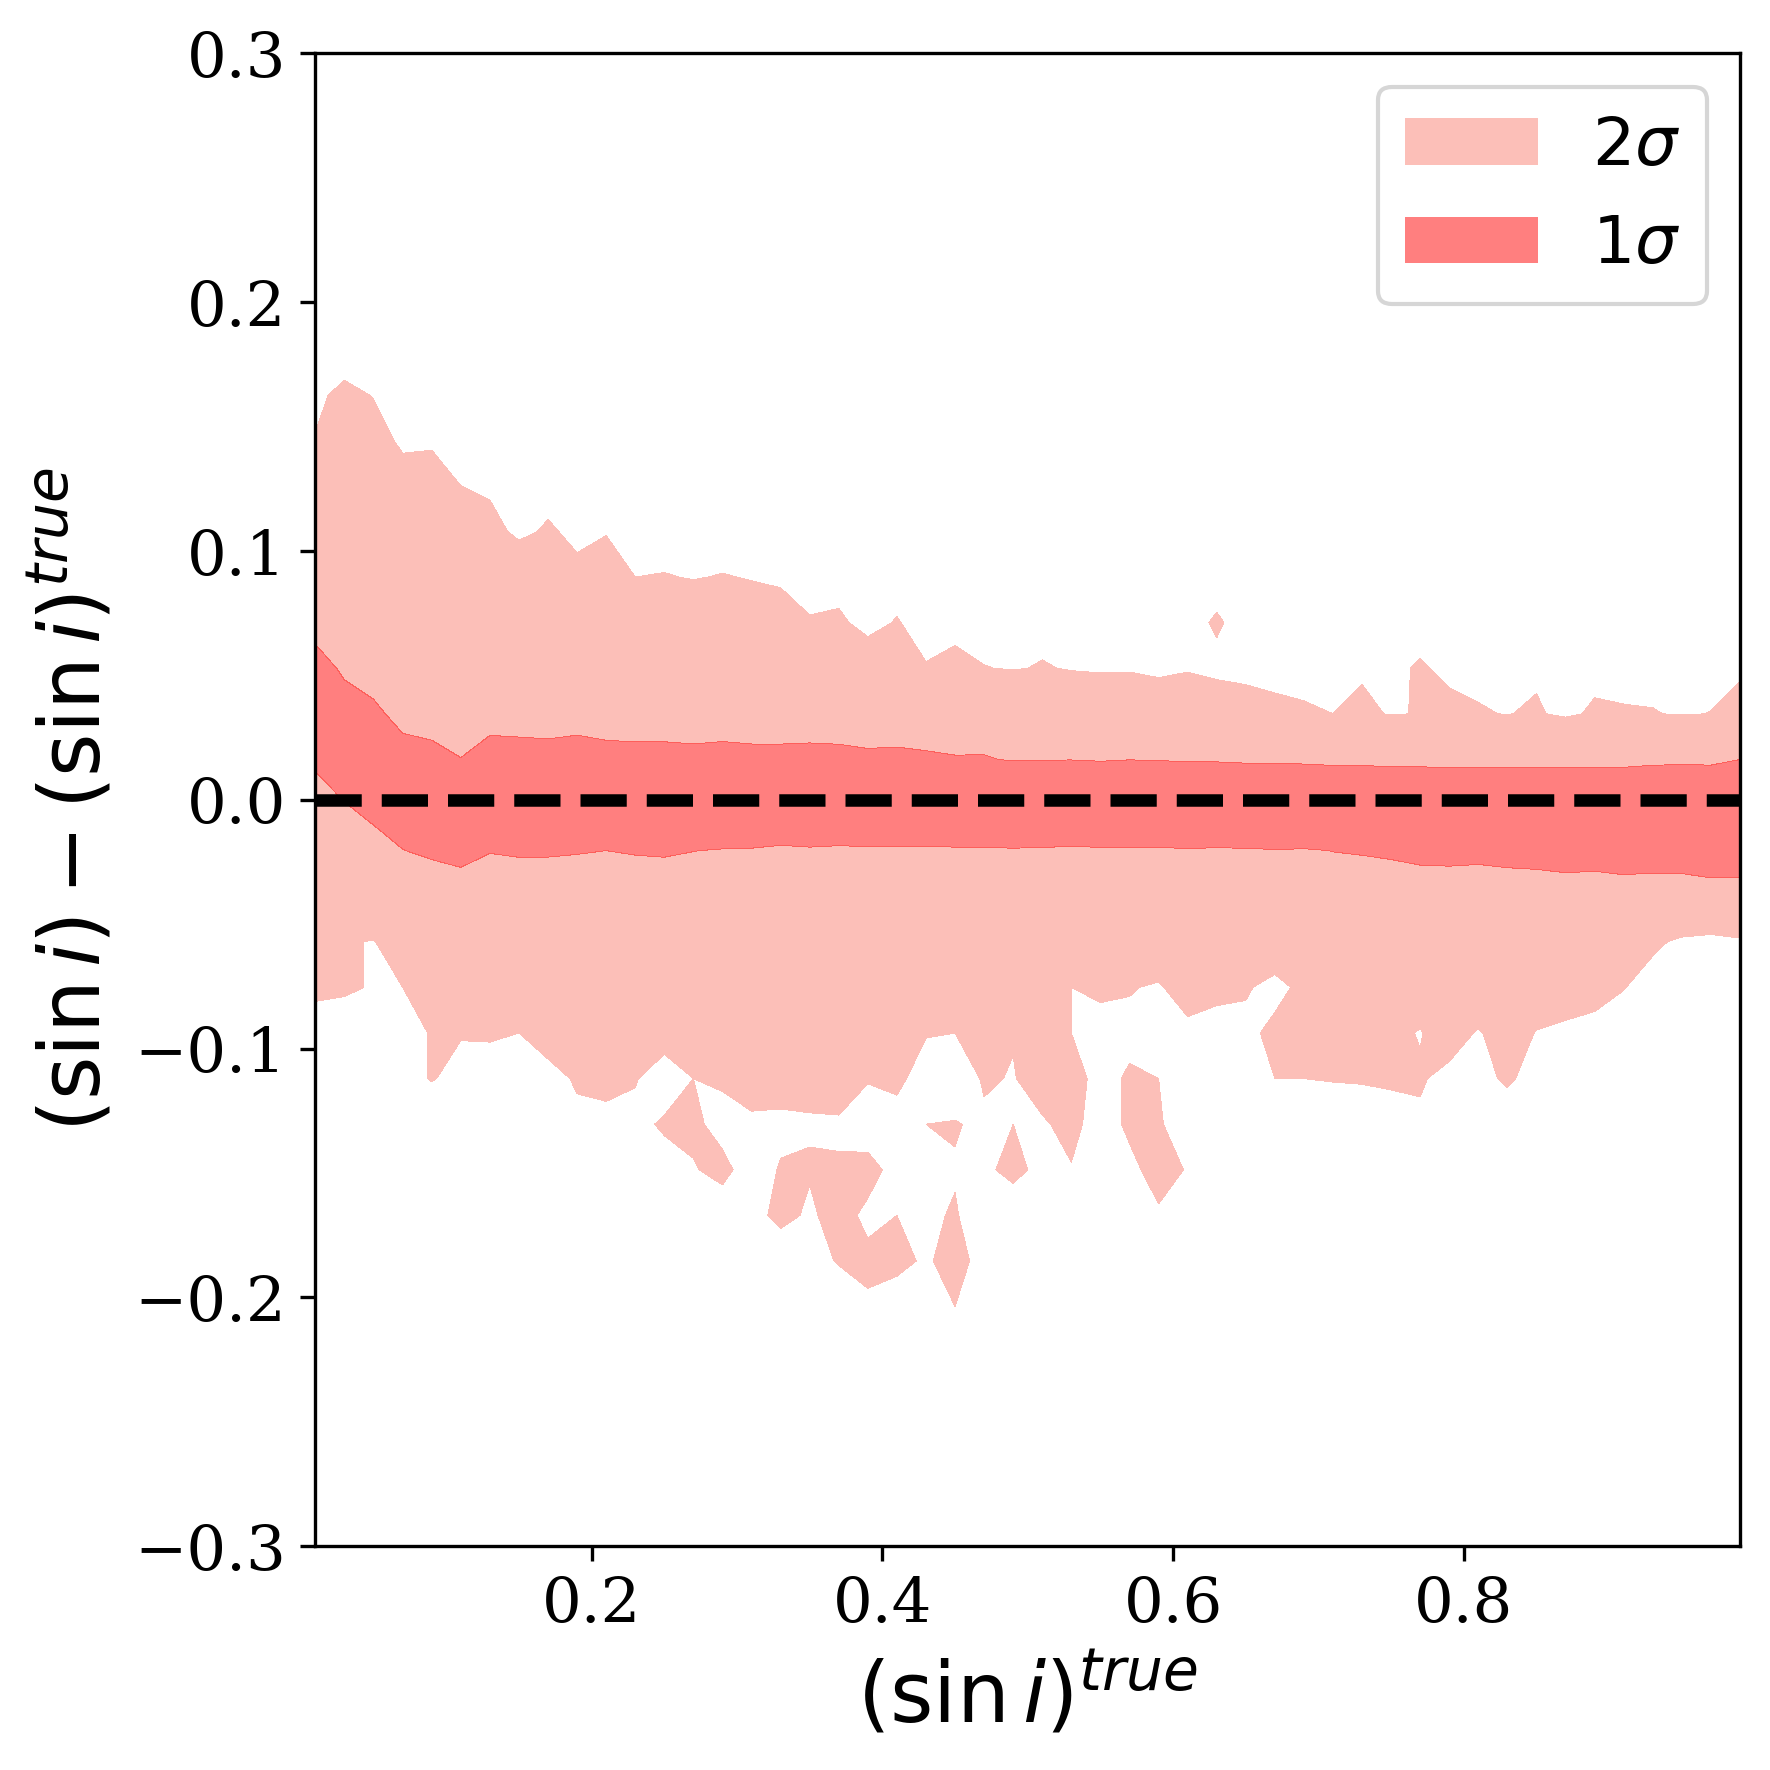

In [19]:
fig = plt.figure(figsize=(6,6))

sini_true = true[:,4]
sini_diff = diff[:,4]
contour = density_contour(sini_true, sini_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-0.3,0.3)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$(\sin i)^{true}$',fontsize=20)
plt.ylabel(r'$(\sin i)-(\sin i)^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/sini_{stem}_contour.jpg'))
plt.show()

### v0

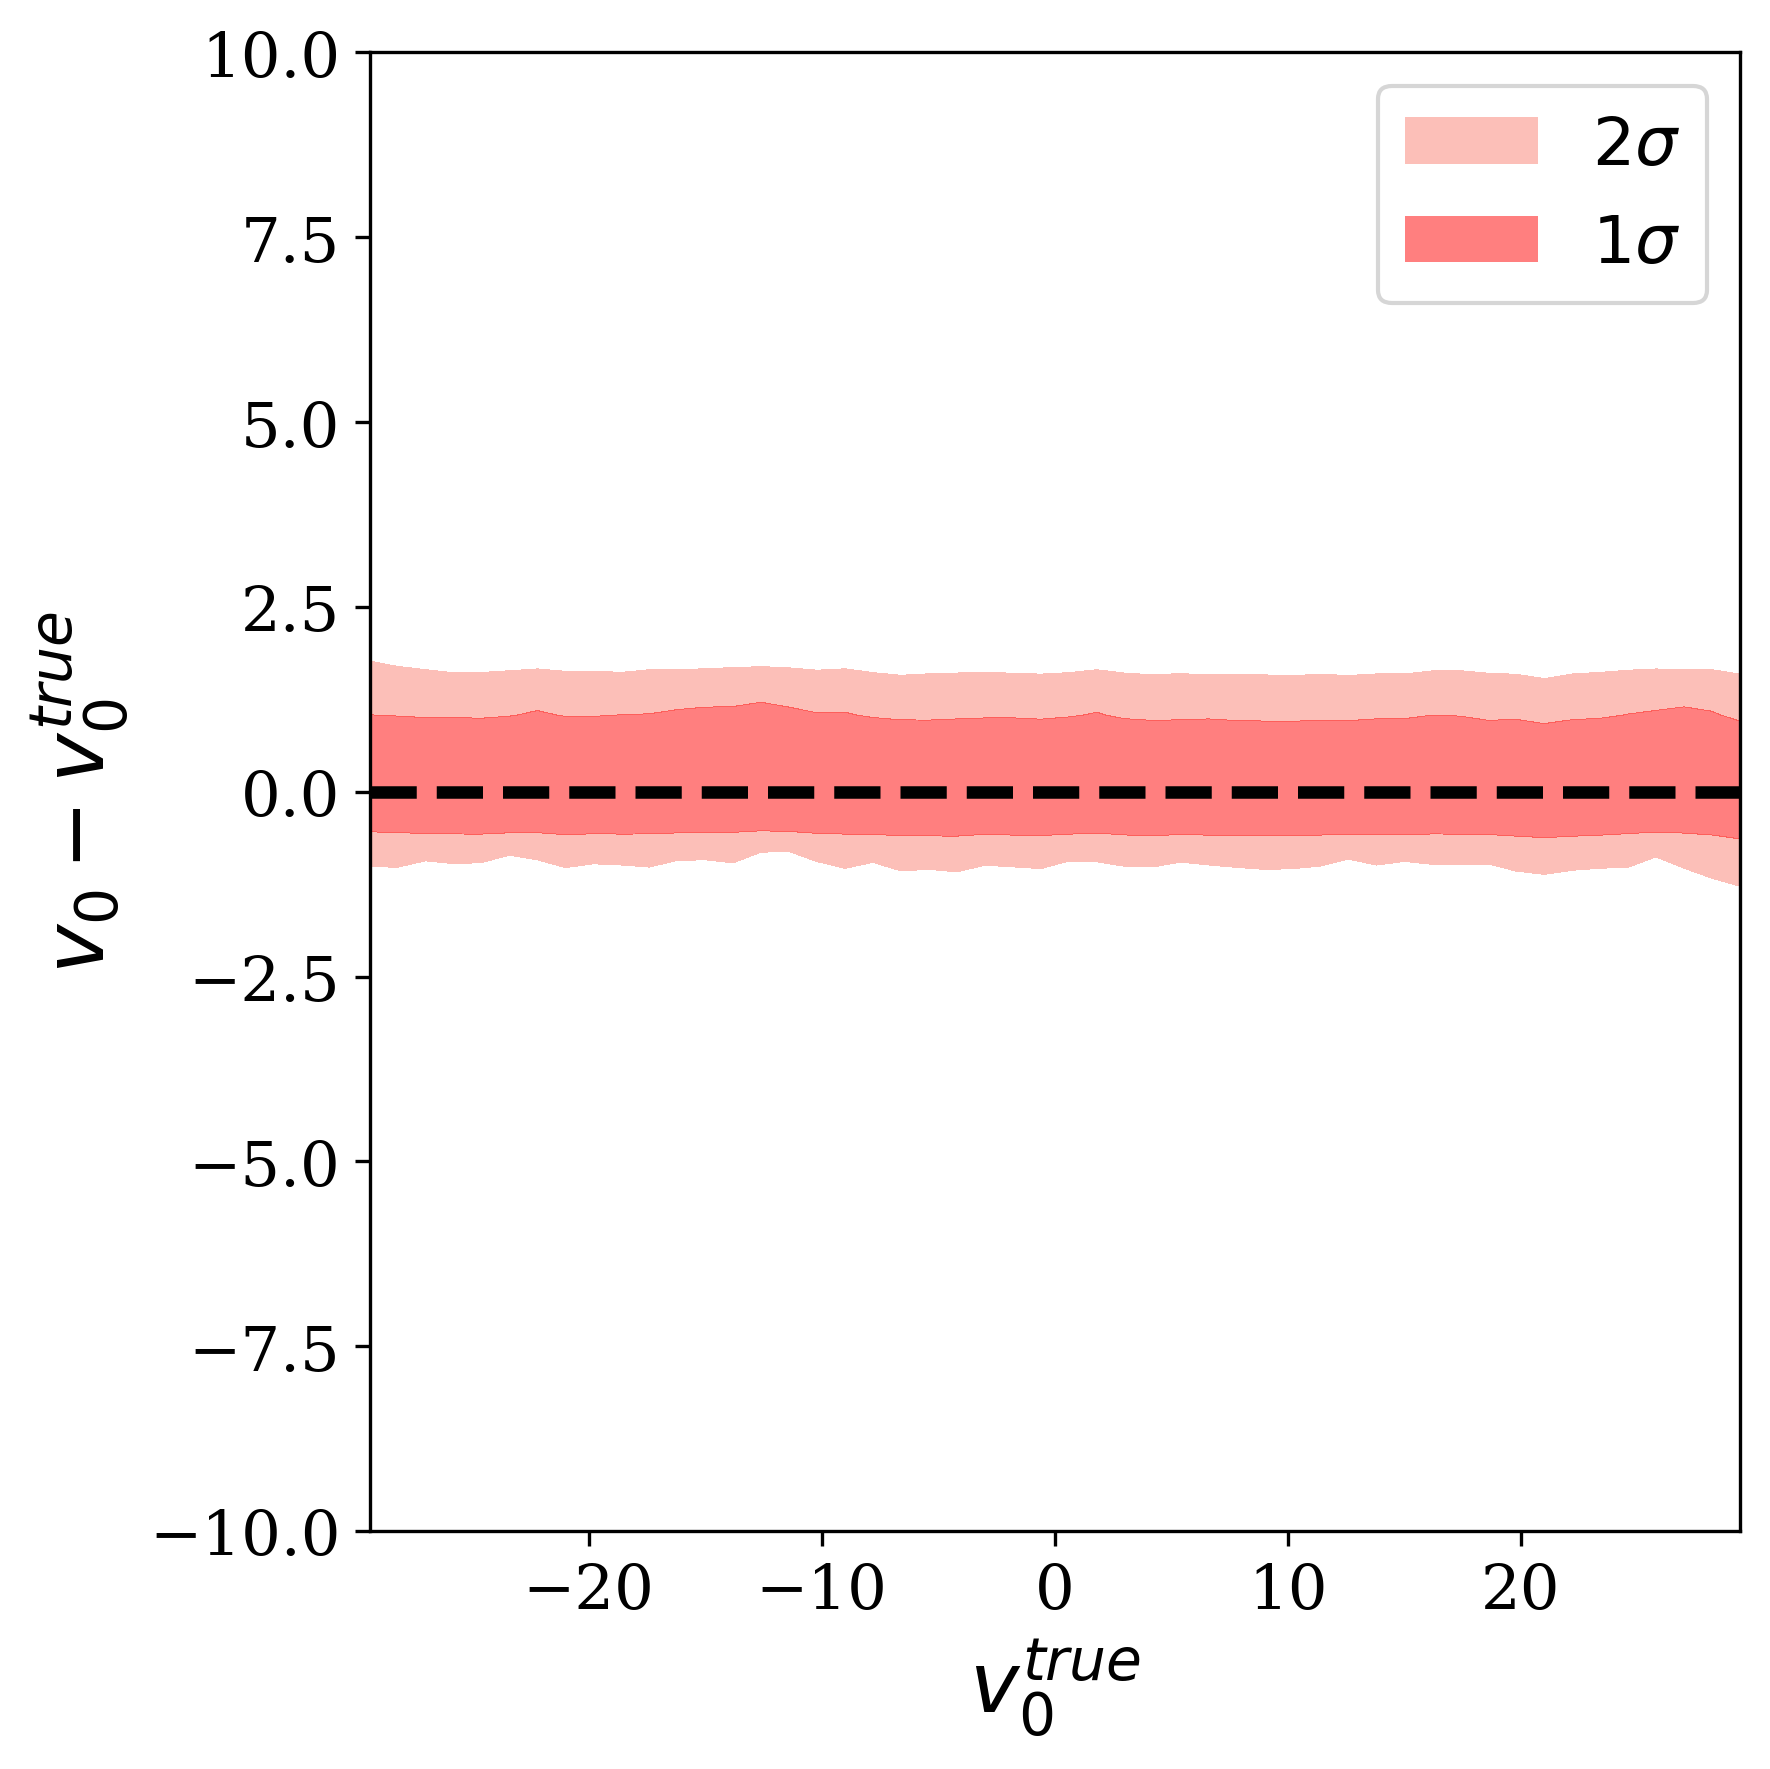

In [20]:
fig = plt.figure(figsize=(6,6))

v0_true = true[:,5]
v0_diff = diff[:,5]
contour = density_contour(v0_true, v0_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-10,10)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$v_0^{true}$',fontsize=20)
plt.ylabel(r'$v_0-v_0^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/v0_{stem}_contour.jpg'))
plt.show()

### vcirc

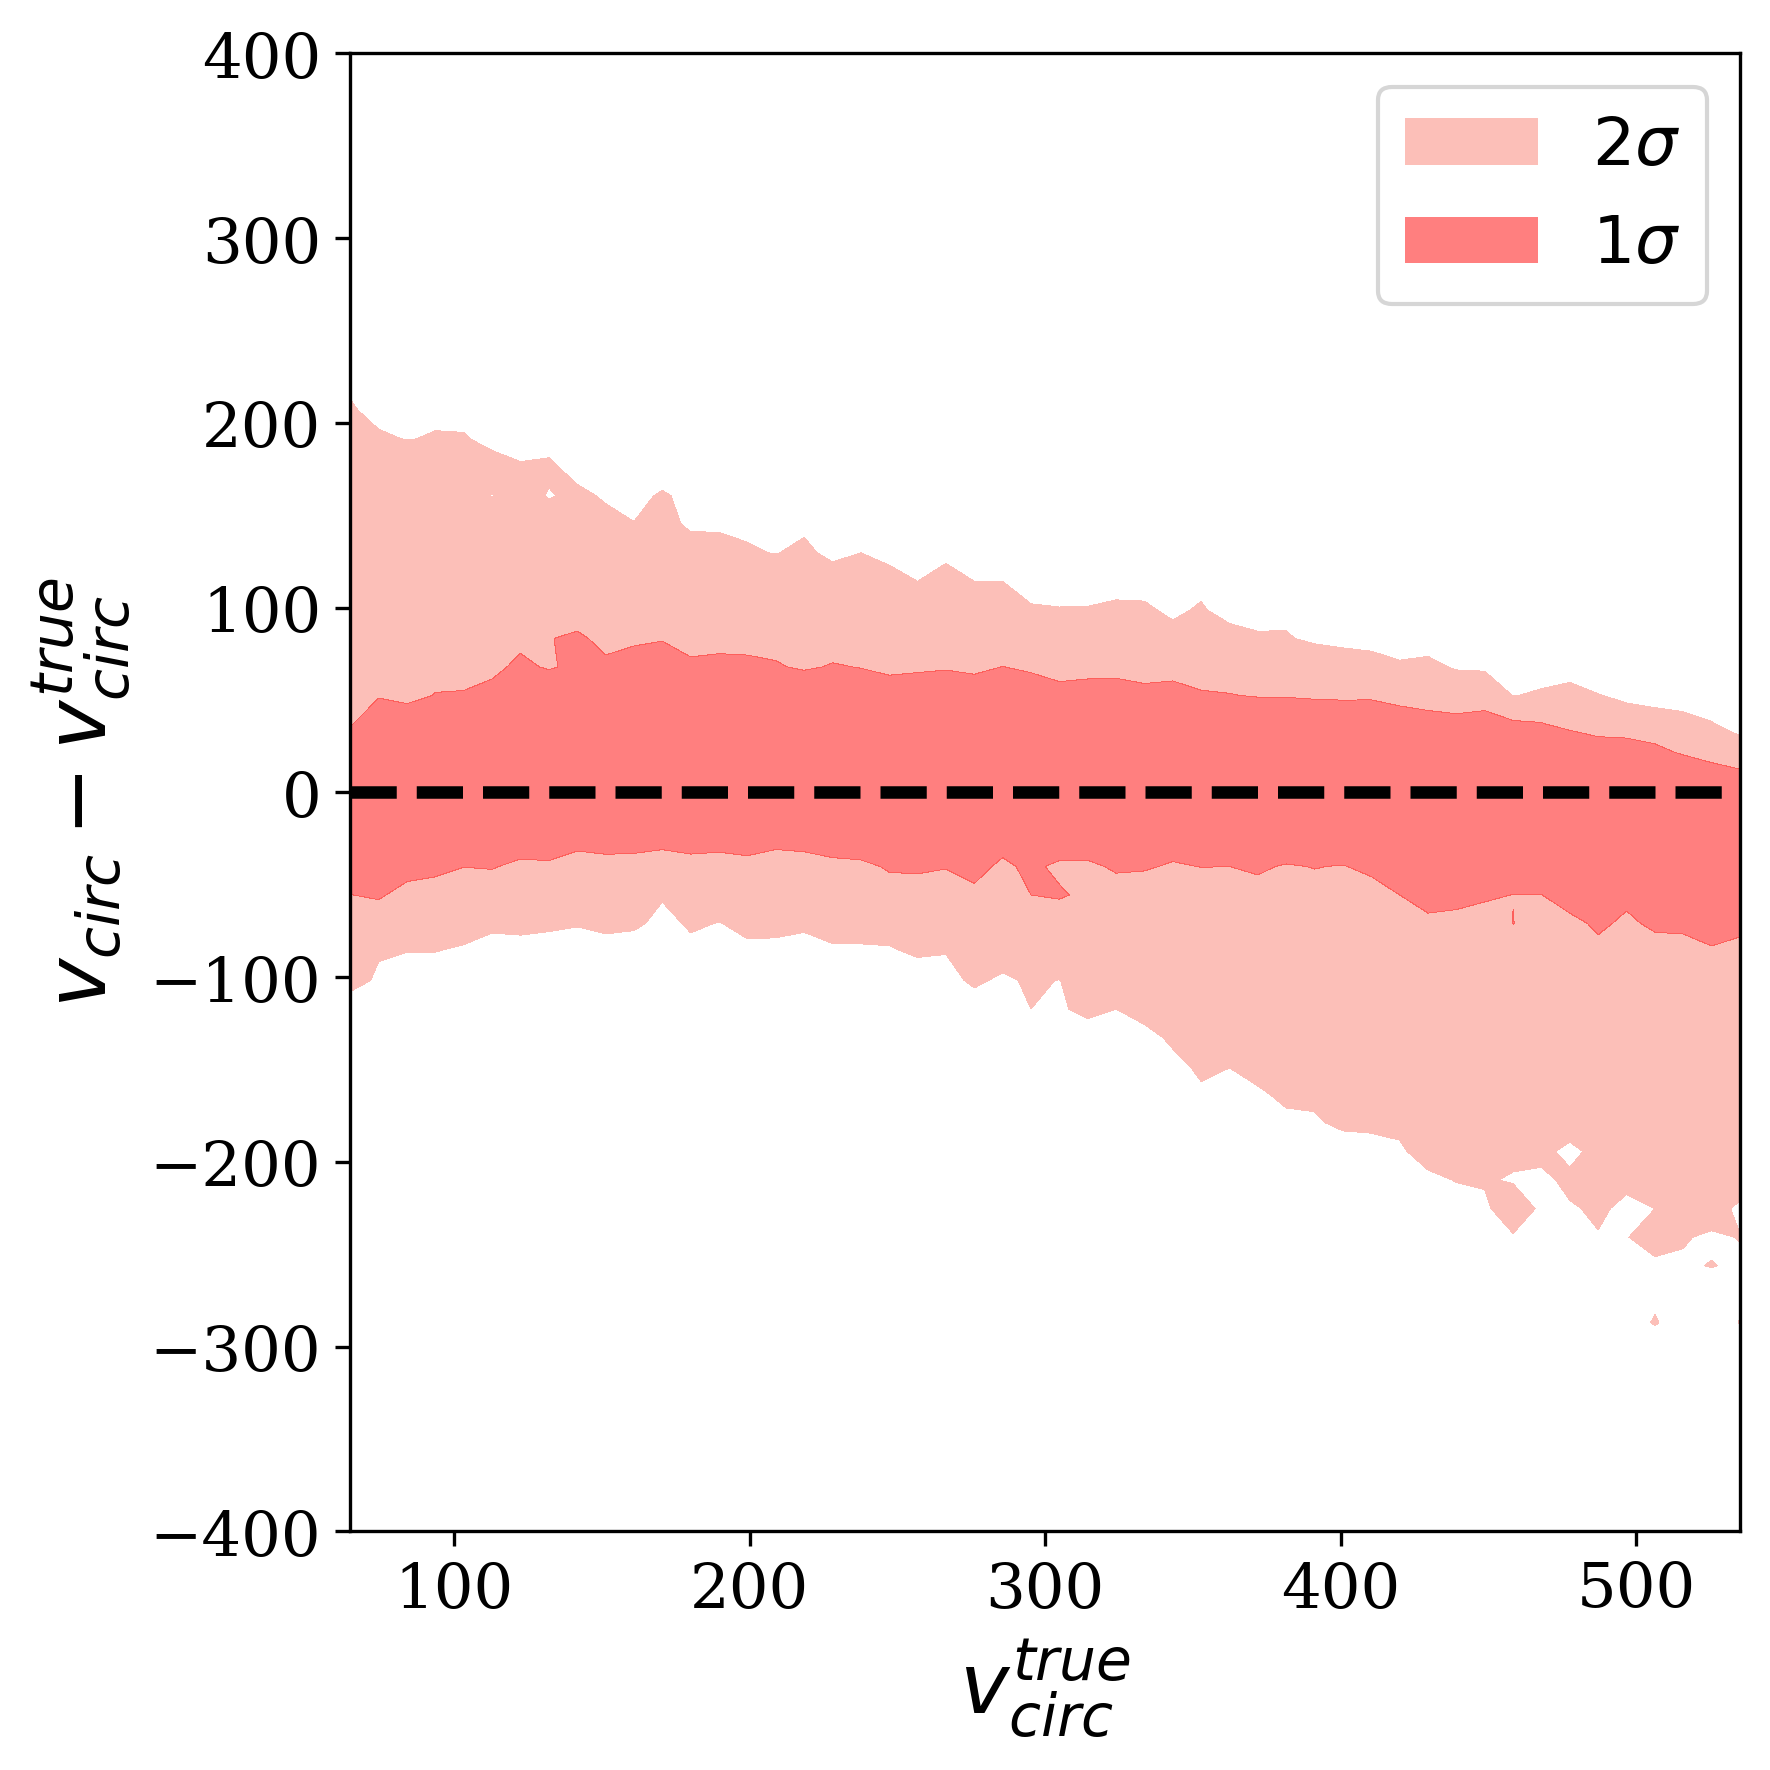

In [21]:
fig = plt.figure(figsize=(6,6))

vcirc_true = true[:,6]
vcirc_diff = diff[:,6]
contour = density_contour(vcirc_true, vcirc_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-400,400)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$v_{circ}^{true}$',fontsize=20)
plt.ylabel(r'$v_{circ}-v_{circ}^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/vcirc_{stem}_contour.jpg'))
plt.show()

### rscale

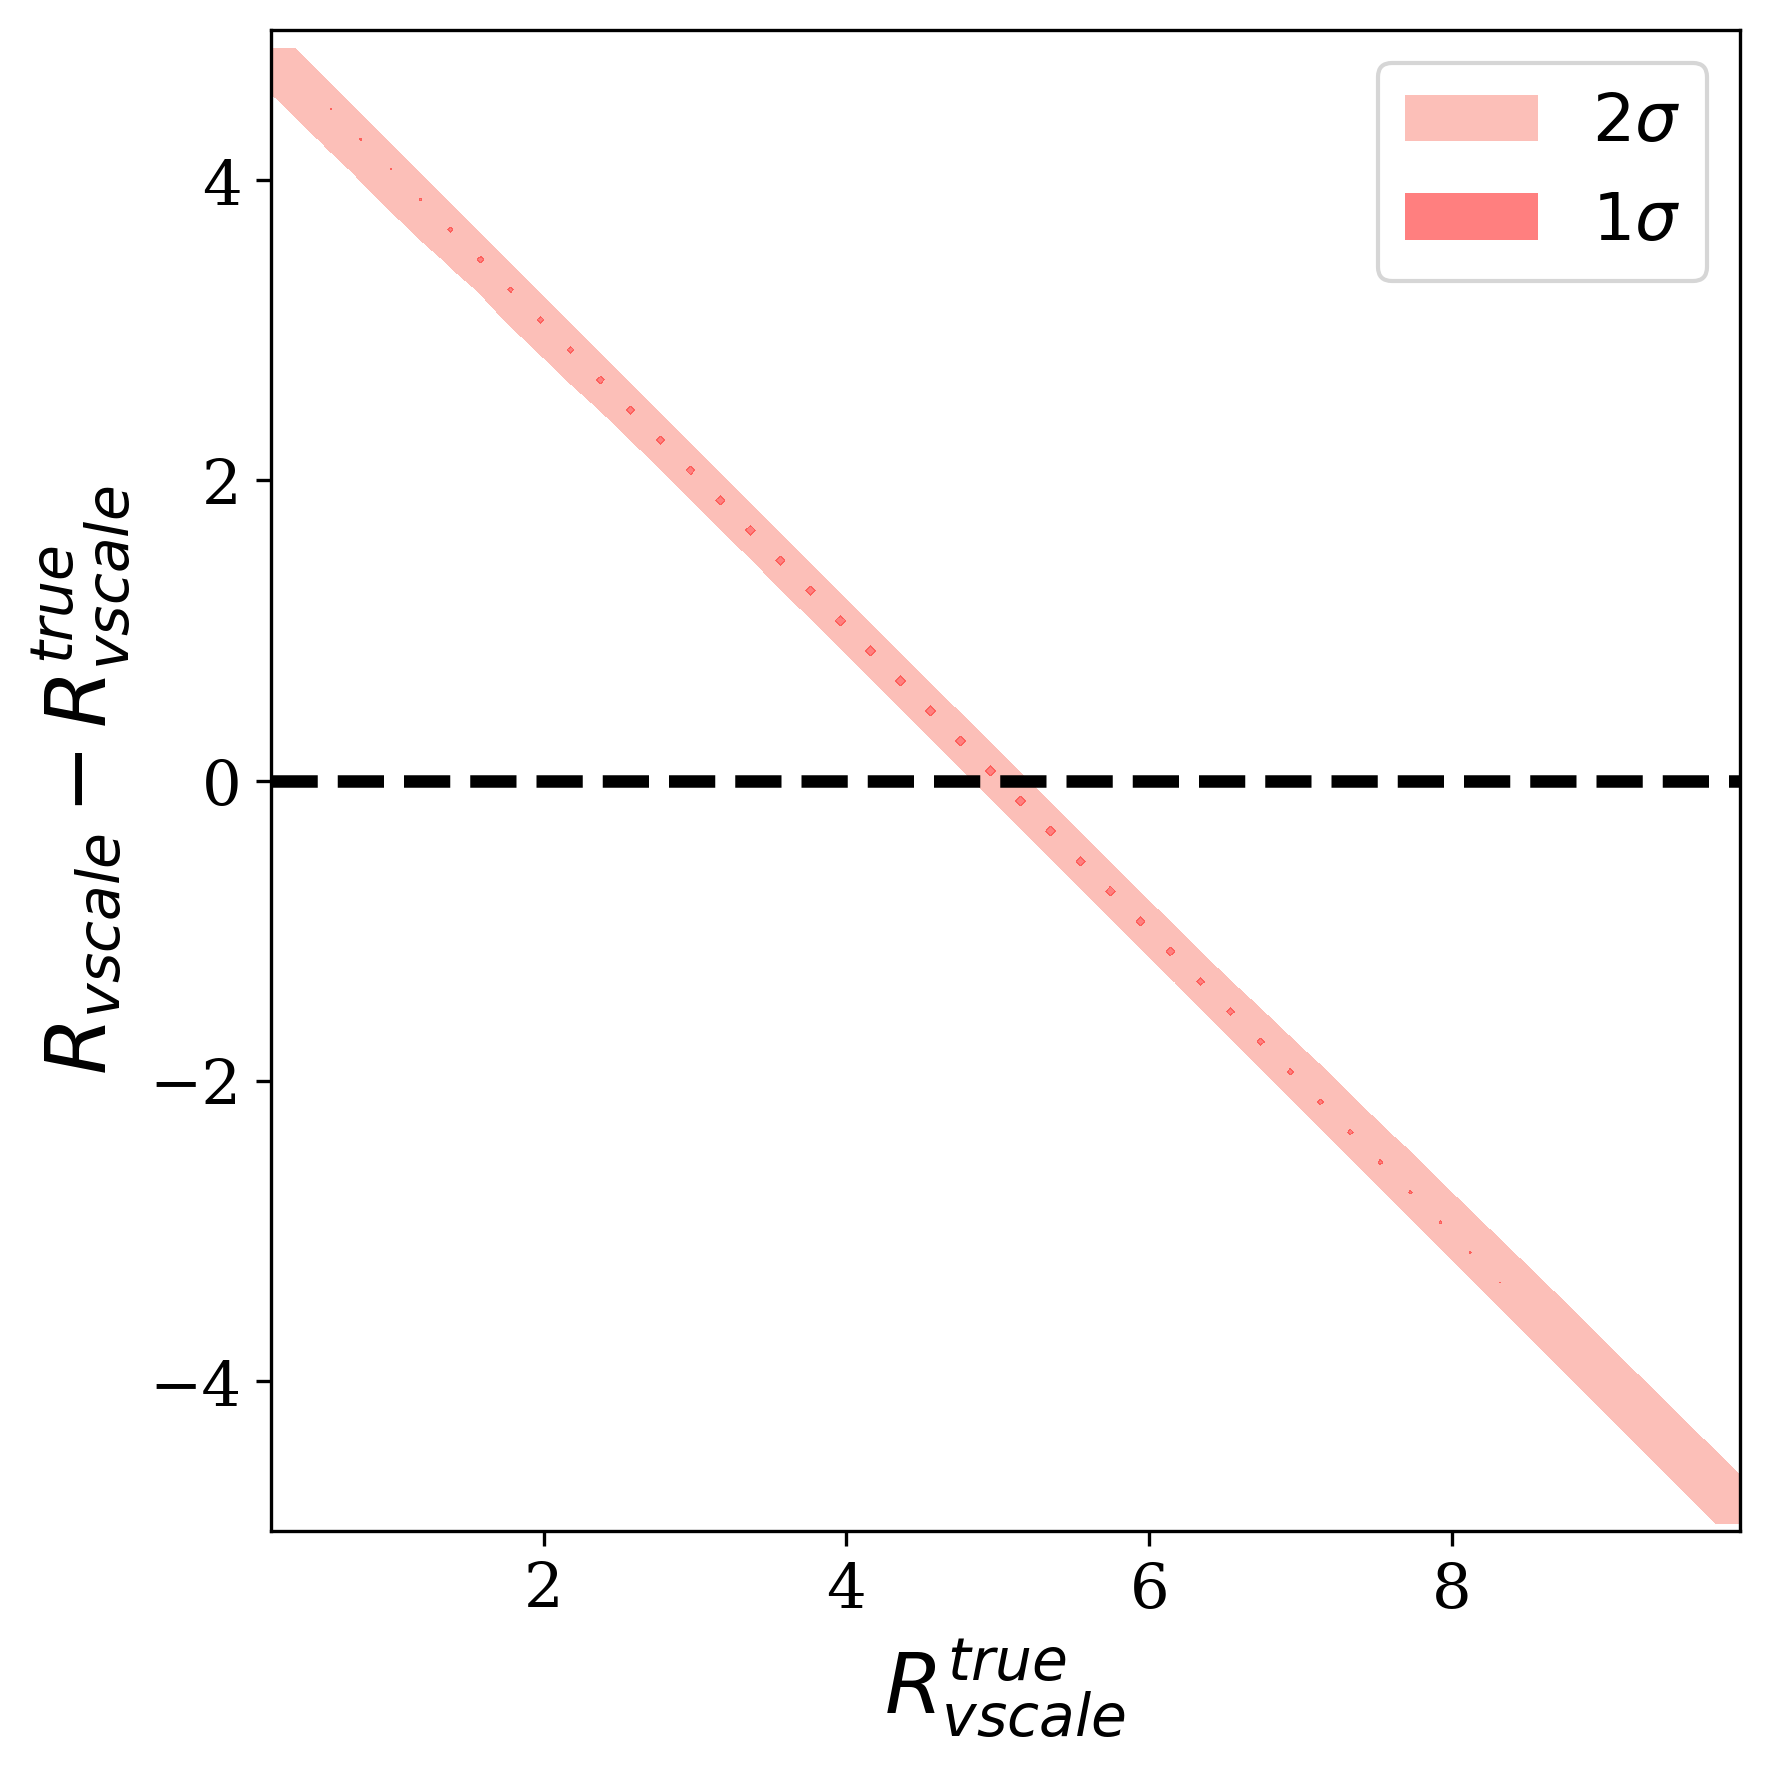

In [27]:
fig = plt.figure(figsize=(6,6))

rscale_true = true[:,7]
rscale_diff = diff[:,7]
contour = density_contour(rscale_true, rscale_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-5, 5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$R_{vscale}^{true}$',fontsize=20)
plt.ylabel(r'$R_{vscale}-R_{vscale}^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/rscale_{stem}_contour.jpg'))
plt.show()

### hlr

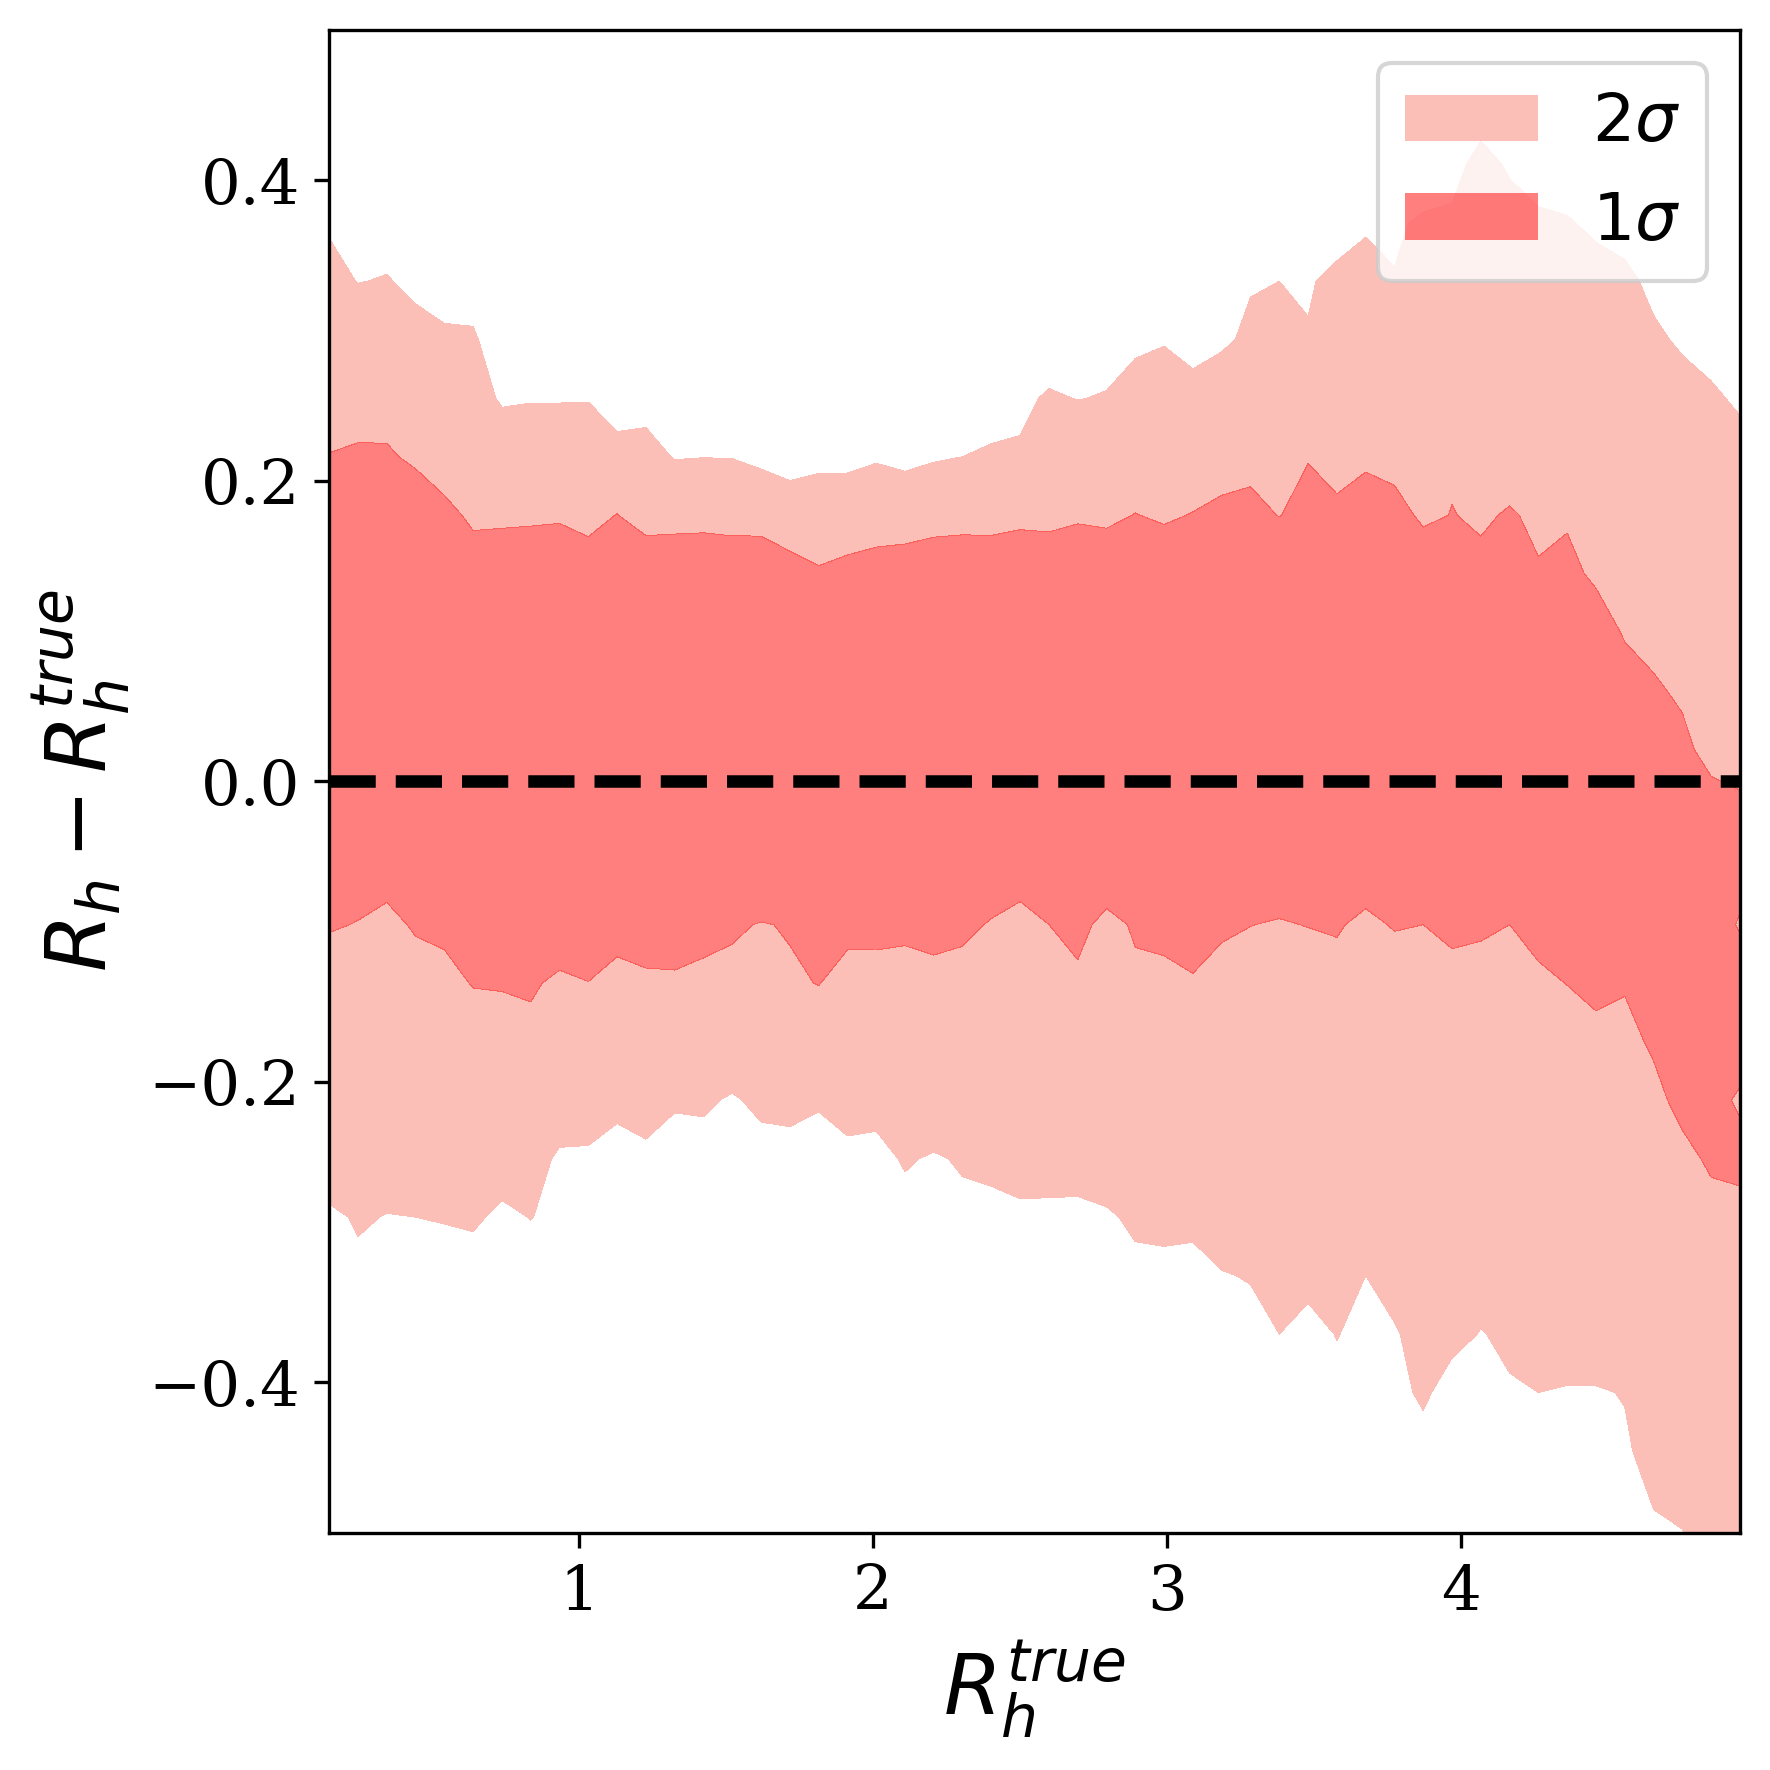

In [26]:
fig = plt.figure(figsize=(6,6))

hlr_true = true[:,8]
hlr_diff = diff[:,8]
contour = density_contour(hlr_true, hlr_diff, 50, 50, colors=['salmon', 'red'])
plt.ylim(-0.5, 0.5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$R_h^{true}$',fontsize=20)
plt.ylabel(r'$R_h-R_h^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/hlr_{stem}_contour.jpg'))
plt.show()

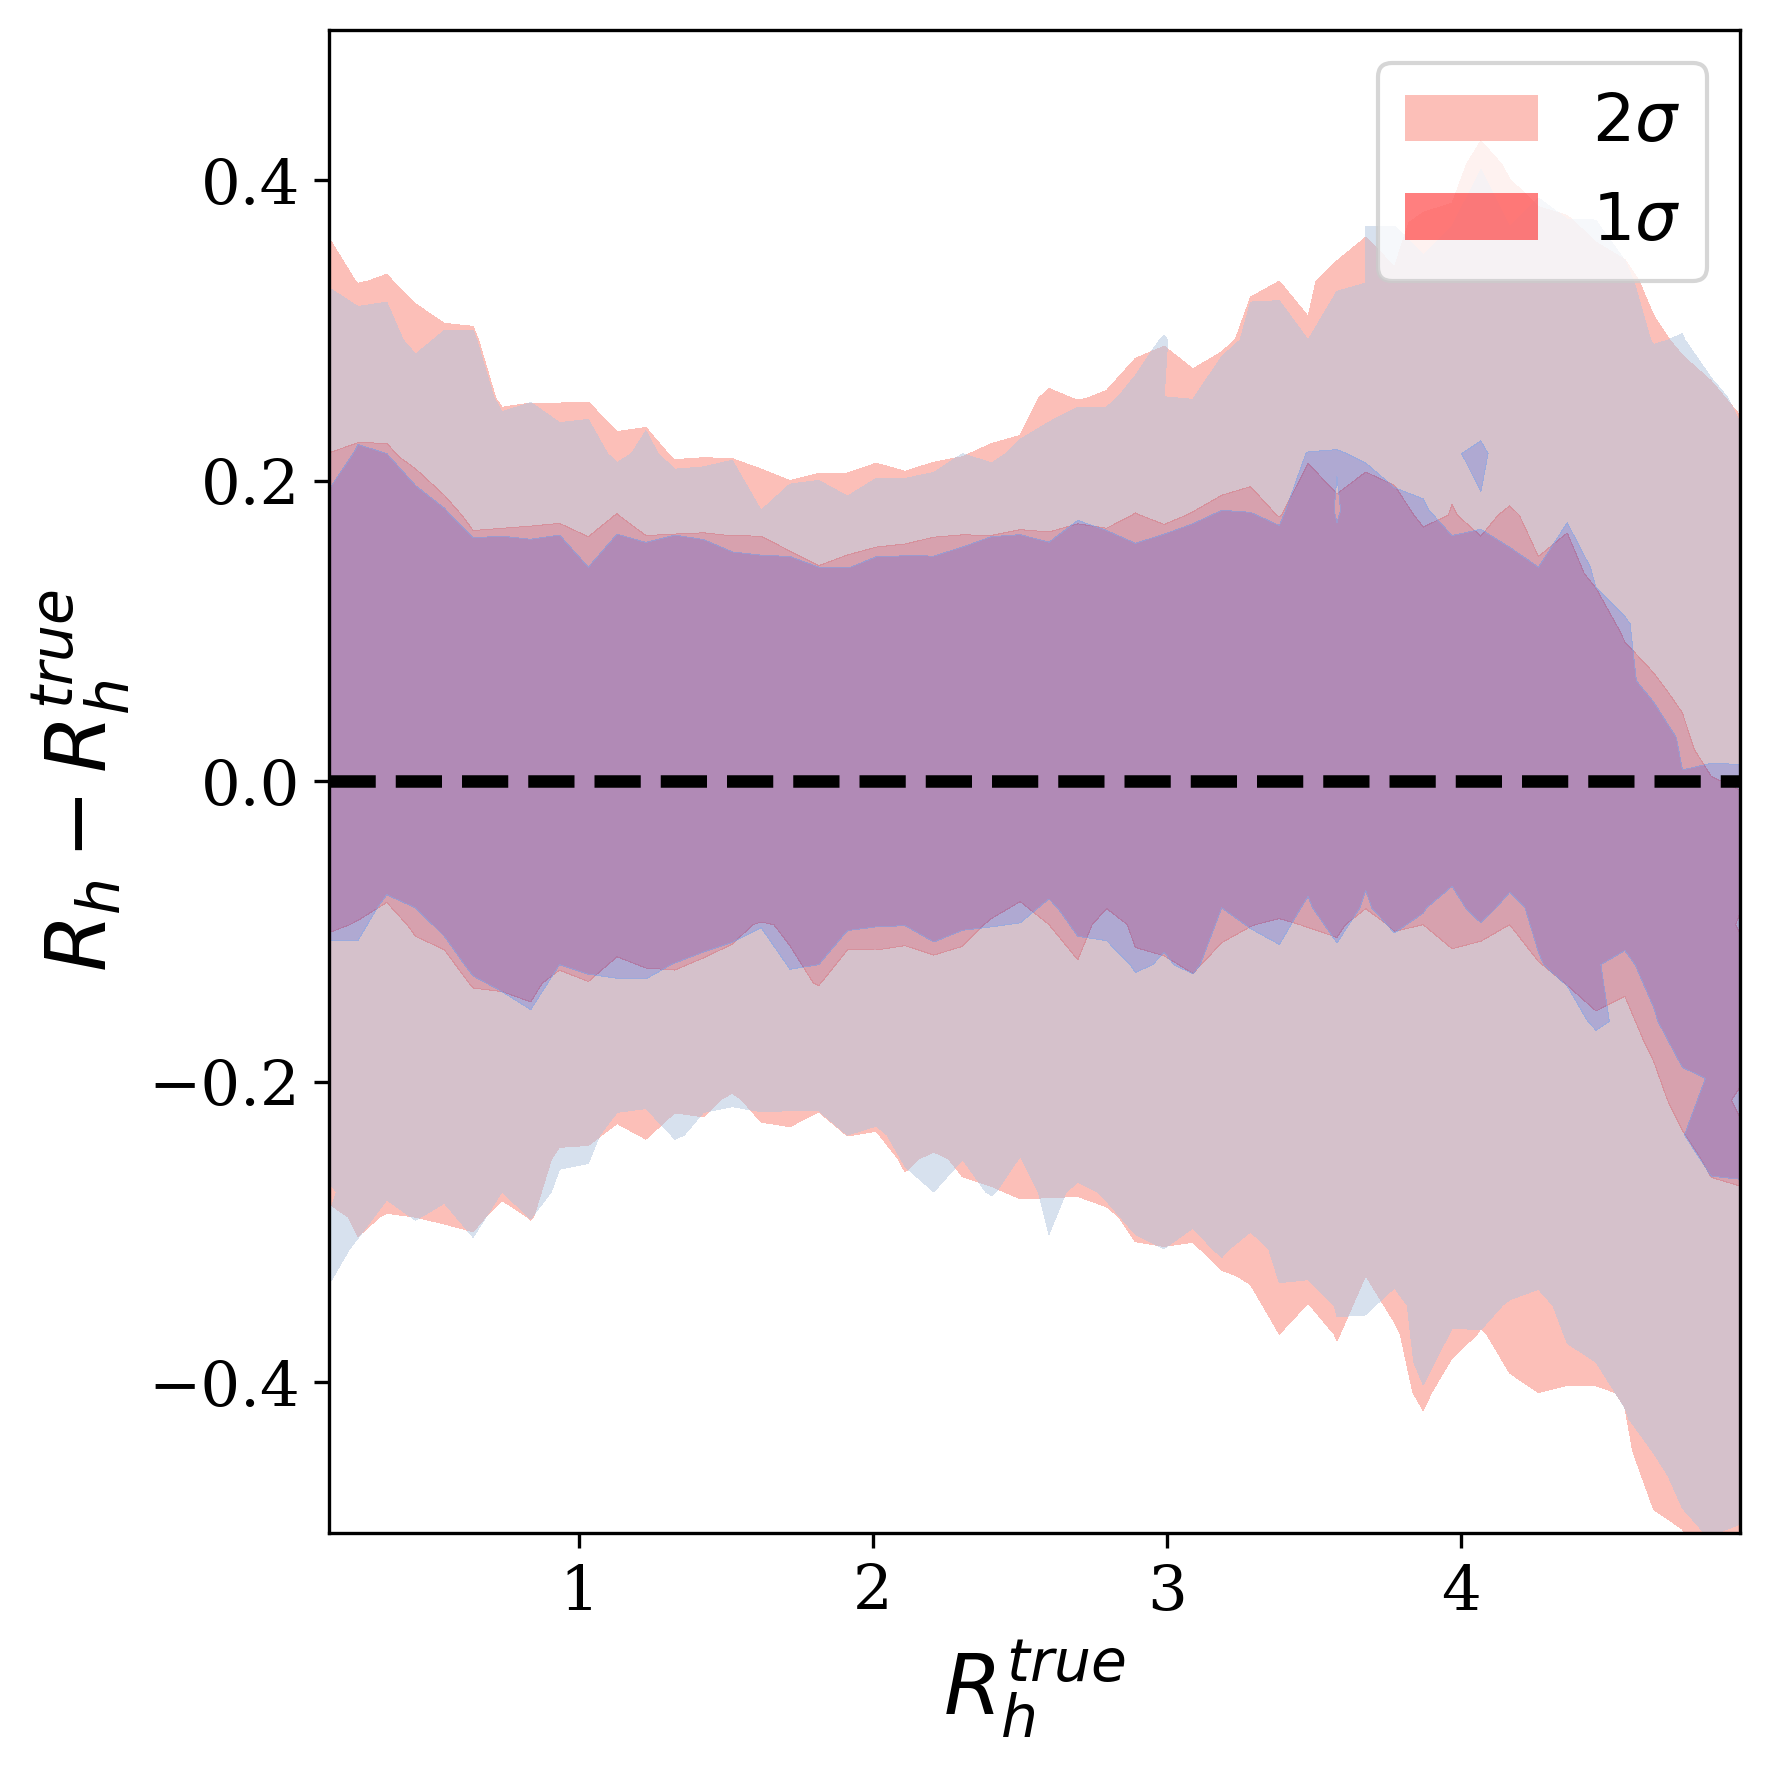

In [25]:
fig = plt.figure(figsize=(6,6))

hlr_true = true[:,8]
hlr_diff = diff[:,8]
snr_mask = SNR > 100

contour = density_contour(hlr_true, hlr_diff, 50, 50, colors=['salmon', 'red'])
contour1 = density_contour(hlr_true[snr_mask], hlr_diff[snr_mask], 50, 50, colors=['lightsteelblue', 'cornflowerblue'])
plt.ylim(-0.5, 0.5)

plt.axhline(0,color='k',linestyle='--',linewidth=3)
    
plt.xlabel(r'$R_h^{true}$',fontsize=20)
plt.ylabel(r'$R_h-R_h^{true}$',fontsize=20)

plt.tick_params(axis='both',which='major',labelsize=15)

handles, labels = contour.legend_elements()
plt.legend(handles, [r'$2\sigma$', r'$1\sigma$'], fontsize=16)

plt.tight_layout()
plt.savefig(join(fig_dir, f'{stem}/hlr_{stem}_contour.jpg'))
plt.show()

In [23]:
dividers = [0.2, 0.2, np.pi, 1, 60, 480, 9.9, 4.9]

In [24]:
avg_diff = np.average(np.abs(diff), axis=0)
avg_diff[1:] /= dividers
print(avg_diff)
np.save(join(results_dir, f'avgdiff_{stem}'), avg_diff)

[0.         0.16660791 0.16713161 0.17044985 0.11324229 0.25000166
 0.25006218 0.25001846 0.02568189]
